# Qualidade do ar e problemas respiratórios na região metropolitana de Salvador-Bahia: uma análise estatística

Comando para baixar o shapefile do terrítorio brasileiro

In [7]:
# Download Brazil territorial meshes
!wget -r -np -nH -N -R "*.html" --no-directories --directory-prefix=meshes_br2018 \
    ftp://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2018/Brasil/BR/ \
    ftp://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2018/Leia_me_Malha_Digital_2018.pdf

--2020-04-01 23:36:05--  ftp://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2018/Brasil/BR/
           => ‘meshes_br2018/.listing’
Resolving geoftp.ibge.gov.br (geoftp.ibge.gov.br)... 170.84.40.11
Connecting to geoftp.ibge.gov.br (geoftp.ibge.gov.br)|170.84.40.11|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2018/Brasil/BR ... done.
==> PASV ... done.    ==> LIST ... done.

.listing                [ <=>                ]     501  --.-KB/s    in 0s      

2020-04-01 23:36:10 (29.0 MB/s) - ‘meshes_br2018/.listing’ saved [501]

Removed ‘meshes_br2018/.listing’.
--2020-04-01 23:36:10--  ftp://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2018/Brasil/BR/BR.zip
           => ‘meshes_br2018/BR.zip’
==> CWD not required.
==> PASV ... done.    =

Índices do IBGE dos municípios da região metropolitana de Salvador

Cidade|População [2010]|População estimada [2019]|Densidade demográfica (hab/km² )|PIB per capita [2017]|Mortalidade Infantil [2017] (óbitos/mil nascidos vivos)|Estabelecimentos de Saúde SUS [2009]|Homens <5|Mulheres <5|Homens >60|Mulheres >60
---|---|---|---|---|---|---|---|---|---|---
Salvador|2.675.656|2.872.347|3.859,44|BRL21.231,48|14,56|367|83.611|81.658|101.464|165.689
Camaçari|242.970|299.132|309,65|BRL 77.816,68|12,1|64|10.465|9.614|6.601|7.605
São Francisco do Conde|33.183|39.183|126,24|BRL 253.895,58|9,48|22|1.344|1.349|972|1.274
Lauro de Freitas|163.449|198.440|2.833,38|BRL 31.809,81|13,68|24|6.163|5.832|5.210|6.485
Simões Filho|118.047|134.377|586,65|BRL 39.118,47|14,13|17|5.064|4.973|3.411|4.091
Candeias|83.158|87.076|321,87|BRL 43.135,87|15,9|31|3.192|3.083|2.806|3.591
Dias d'Ávila|66.440|81.089|360,64|BRL 37.896,15|14,42|11|3.003|2.879|1.904|2.235
Mata de São João|40.183|46.583|63,46|BRL 22.407,10|18,23|9|1.672|1.567|1.427|1.789
Pojuca|33.066|39.519|113,97|BRL 21.834,06|17,58|17|1.249|1.262|1.129|1.388
São Sebastião do Passé|42.153|44.300|78,30|BRL 11.965,30|10,58|25|1.504|1.492|1.735|2.104
Vera Cruz|37.567|43.223|125,33|BRL 11.752,15|10,27|19|1.358|1.355|1.821|1.954
Madre de Deus|17.376|21.093|539,61|BRL 21.144,38|21,13|13|615|608|565|750
Itaparica|20.725|22.228|175,58|BRL 9.824,79|30,04|10|796|753|918|1.131

## Importação das bibliotecas

Bibliotecas que foram utilizadas durante as análises

In [1]:
from pandas_profiling import ProfileReport
from ipywidgets import interact, widgets
from IPython.display import Image
from scipy import stats

import matplotlib.pylab as plt
import multiprocessing as mp
import missingno as msno
import seaborn as sns
import pandas as pd
import numpy as np
import glob
import re
import os

In [2]:
%matplotlib inline

## Variáveis globais

Indica onde estão localizados os arquivos contendo os dados:

- F_AIRQ: qualidade do ar
- F_WTHR: meteorológico
- F_DSUS: internações hospitalares
- PATH_RESULT: caminho para pasta contendo os resultados
- COLS_AIRQ: colunas de interesse do dataframe de qualidade do ar
- COLS_WTHR: colunas de interesse do dataframe meteorológico

In [ ]:
F_AIRQ = '../datas/preprocessing/mr-ssa/airquality/cetrel/interval_1hour/airquality.csv.gz' # interval_15min
F_WTHR = '../datas/preprocessing/mr-ssa/weather/cetrel/weather.csv.gz'
F_DSUS = '../datas/preprocessing/mr-ssa/datasus/RD.csv.gz'
PATH_RESULTS = '../docs/writings/air-pollution/results'

COLS_AIRQ = [
    r'$SO_2$ (µg/m3)',
    'CO (ppm)',
    r'$O_3$ (µg/m3)',
    r'$PM_{10}$ (µg/m3)',
    r'$NO_2$ (µg/m3)',
    'NO (µg/m3)'
]

COLS_WTHR = [
    'V.VEN (m/s)',
    'D.VEN (Deg)',
    'TEMP (C°)',
    'UMID (%)',
    'CHUVA (mm)',
]

## Funções

Função para exibição de uma lista enumerada

- arr: lista a ser enumerada

return: retorna uma lista enumerada (dicionário)

In [4]:
def show_enum(arr: [str]) -> {int: str}:
    return {idx: value for (idx, value) in enumerate(arr)}

Função que recebe um dataframe como entrada e gera um dataframe de saída com a descrição dos dados.

- df: dataframe a ser descrito
- headers: colunas a serem analisadas

return: retorna um dataframe com a descrição de cada coluna

In [5]:
def describe_data(
    df: pd.DataFrame, headers: [str] = None
) -> pd.DataFrame:

    def _apply(header: str, column: []):
        _max = column.max()
        _min = column.min()

        _q1 = column.quantile(0.25)
        _q3 = column.quantile(0.75)
        _iqr = _q3 - _q1
        _lower = max(_min, _q1 - (1.5 * _iqr))
        _upper = min(_max, _q3 + (1.5 * _iqr))
            

        return {
            'header': header,
            'max': _max,
            'min': _min,
            'mean': column.mean(),
            'median': column.median(),
            'lower-limit': _lower,
            'quartile-1': _q1,
            'quartile-3': _q3,
            'upper-limit': _upper,
            'var': column.var(),
            'std': column.std(),
            'mad': column.mad(),
            'amp': _max - _min,
            'rms': (column.pow(2)).mean() ** 0.5,
            'kurtosis': column.kurtosis(),
            'skew': column.skew(),
            'count': column.count(),
            'nans': column.isna().sum(),
        }

    if not headers:
        headers = df.columns

    return pd.DataFrame(
        [_apply(h, df[h]) for h in headers]
    ).set_index('header')

Exibe a descrição dos dados e as informações do dataframe

- df: dataframe a ser descrito
- columns: colunas a serem analisadas

In [6]:
def show_describe(df: pd.DataFrame, columns: [str]) -> None:
    display(describe_data(df, columns))
    display(df.info())

Exibe o profiling do dataframe e salva em um caminho

- df: dataframe a ser analisado
- title: título a ser atribuido no profiling
- f_out: path para o arquivo de saida

In [7]:
def show_profiling(
    df: pd.DataFrame, title: str = None, f_out: str = None
) -> None:
    prof = ProfileReport(df, title=title)
    prof.to_widgets()
    if f_out:
        prof.to_file(output_file=f_out)

Função para exibir o gráfico de densidade de distribuição e boxplot

- dataset: dataframe de exibição
- out: se != None, salva o resultado no caminho informado

In [150]:
# Third-party function (Adapted from Lucas Lucas Alves)
def plot_distributions(dataset: pd.DataFrame, out: str = None) -> None:
    dataset_columns = list(dataset.columns.values)
    plt_col_num = 2
    plt_row_num = len(dataset_columns)
    
    plt.figure(figsize=(15, plt_row_num*5))
    
    for index, label in enumerate(dataset_columns):
        # Subplot for histogram and KDE
        plt.subplot(plt_row_num, plt_col_num, (2*index)+1)
        
        # Plot histogram
        ax1 = sns.distplot(dataset.loc[:, label].dropna(), hist=True, kde=False)
        ax1.set_ylabel('Frequency')
        
        # Plot KDE (Kernel Density Estimation)
        ax2 = ax1.twinx()
        sns.distplot(dataset.loc[:, label].dropna(), hist=False, kde=True, ax=ax2)
        ax2.set_ylabel('Kernel density estimation')

        # Computation of data statistics
        median = dataset.loc[:, label].median()
        quartile_1 = dataset.loc[:, label].quantile(q=0.25)
        quartile_3 = dataset.loc[:, label].quantile(q=0.75)
        min_val = dataset.loc[:, label].min()
        max_val = dataset.loc[:, label].max()
        inf_limit = max(min_val, (quartile_1 - (quartile_3-quartile_1)*1.5))
        sup_limit = min(max_val, (quartile_3 + (quartile_3-quartile_1)*1.5))
        
        # Computation of outliers
        inf_outliers = dataset.loc[dataset.loc[:, label]<inf_limit, :].shape[0]
        sup_outliers = dataset.loc[dataset.loc[:, label]>sup_limit, :].shape[0]
        inf_outliers_percent = (inf_outliers/dataset.loc[:, label].dropna().shape[0])
        sup_outliers_percent = (sup_outliers/dataset.loc[:, label].dropna().shape[0])
        
        # Plot lines indicating the statistics
        plt.axvline(x=median, linestyle='-', linewidth=1.3, color='black', label='Median')
        plt.axvline(x=quartile_1, linestyle='-', linewidth=1.3, color='green', label='1st Quartile')
        plt.axvline(x=quartile_3, linestyle='-', linewidth=1.3, color='green', label='3rd Quartile')
        plt.axvline(x=inf_limit, linestyle='-', linewidth=1.3, color='red',
                    label='Lower limit\n{:.2%} of the data below'.format(inf_outliers_percent))
        plt.axvline(x=sup_limit, linestyle='-', linewidth=1.3, color='red',
                    label='Upper limit\n{:.2%} of the data above'.format(sup_outliers_percent))
        plt.legend()
        
        # Plot boxplot in other subplot
        plt.subplot(plt_row_num, plt_col_num, (2*index)+2)
        dataset.boxplot(column=label)
        plt.ylabel('Values')
        plt.title('')
        plt.grid(True)
        
    plt.subplots_adjust(wspace=0.35, hspace=0.3)
    plt.show()
    
    if out:
        plt.savefig(out)

Conversor de ppm|ppb para µg/m3

- value: valor em ppb ou ppm
- mass: massa da molecula
- temp: temperatura
- ppx: indicador de escala ppb ou ppm

return: retorna o valor em escala µg/m3

In [72]:
def ppx2um(value: float, mass: float, temp: float, ppx: str ='ppb'):
    if ppx == 'ppm':
        value *= 1e3
    return (value*12.187*mass)/(273.15+temp)

Função para converter a escala dos poluentes de ppb para µg/m3

- row: identificador da linha
- df: dataframe para conversão
- cols: colunas de df que deseja converter
- dftp: dataframe com as temperaturas
- dtemp: temperatura padrão adotada se não encontrado no dataframe

return: retorna a linha informada com a respectiva conversão

In [121]:
func = {
    'SO2': lambda v, t, ug: ppx2um(v, 64.066, t, ug),
    'O3': lambda v, t, ug: ppx2um(v, 48, t, ug),
    'NO2': lambda v, t, ug: ppx2um(v, 46.0055, t, ug),
    'NO': lambda v, t, ug: ppx2um(v, 30.01, t, ug)
}

def convert(
    row, df: pd.DataFrame, cols: [str], dftp: pd.DataFrame, dtemp: float
):
    aux = df.loc[[row]]
    try:
        temp = dftp.loc[row, 'TEMP (C°)']
        if np.isnan(temp):
            temp = dtemp
    except KeyError:
        temp = dtemp
        
    for col in cols:
        sp = re.search(r'(.*?) ', col).group(1) # specie
        ug = re.search(r'\((.*?)\)', col).group(1) # unit_greatness
        aux.loc[row, col] = func[sp](aux.loc[row, col], temp, ug)
    
    return aux

## Análise descritiva

### Air quality

#### Dataframe

Leitura e exibição do dataframe contendo os dados de qualidade do ar com as concentrações dos poluentes:

- SO2: Dióxido de enxofre
- CO: Monóxido de carbono
- O3: Ozônio
- MP: material particulado
- NO2: Dióxido de nitrogénio
- NO: Óxido nítrico

In [134]:
df_airq = pd.read_csv(
    F_AIRQ,
    low_memory=False,
    index_col='Date & Time',
    parse_dates=['Date & Time'],
    compression='gzip'
)
df_airq

SO2 (ppb)  CO (ppm)  O3 (ppb)  MP (µg/m3)  NO2 (ppb)  \
Date & Time                                                                 
2013-09-01 04:00:00        NaN      0.12       NaN         NaN       9.00   
2013-09-01 05:00:00        1.4      0.15       7.3         NaN      11.80   
2013-09-01 06:00:00        0.6      0.14       6.2         NaN      11.00   
2013-09-01 07:00:00        0.3      0.08       5.5        13.4      14.20   
2013-09-01 08:00:00        0.4      0.12       3.1        14.0      16.30   
...                        ...       ...       ...         ...        ...   
2015-12-31 20:00:00        0.2      0.08       7.0        18.8      13.18   
2015-12-31 21:00:00        0.1      0.10       7.3        29.5      12.41   
2015-12-31 22:00:00        0.2      0.20       8.1        27.2      12.36   
2015-12-31 23:00:00        0.1      0.22       7.4        23.6      12.04   
2015-12-31 00:00:00        0.0      0.17       8.8        23.2      10.74   

                     NO (ppb)          station        lat        lon  
Date & Time                                                           
2013-09-01 04:00:00     17.10  AV ACM - DETRAN -12.978002 -38.468928  
2013-09-01 05:00:00     19.10  AV ACM - DETRAN -12.978002 -38.468928  
2013-09-01 06:00:00     13.30  AV ACM - DETRAN -12.978002 -38.468928  
2013-09-01 07:00:00     14.80  AV ACM - DETRAN -12.978002 -38.468928  
2013-09-01 08:00:00     33.50  AV ACM - DETRAN -12.978002 -38.468928  
...                       ...              ...        ...        ...  
2015-12-31 20:00:00     22.71     RIO VERMELHO -13.005500 -38.487174  
2015-12-31 21:00:00     19.14     RIO VERMELHO -13.005500 -38.487174  
2015-12-31 22:00:00     18.54     RIO VERMELHO -13.005500 -38.487174  
2015-12-31 23:00:00     20.63     RIO VERMELHO -13.005500 -38.487174  
2015-12-31 00:00:00     14.53     RIO VERMELHO -13.005500 -38.487174  

[264937 rows x 9 columns]

Observando o Dataframe alguns poluentes estão em escala ppb e ppm. Para medida comparativa com os índices exigidos pela [Resolução CONAMA Nº 491/2018](http://www2.mma.gov.br/port/conama/legiabre.cfm?codlegi=740) torna-se necessário a escala em µg/m³. Para tal, os valores foram convertidos utilizando como base a [equação geral](https://www2.dmu.dk/AtmosphericEnvironment/Expost/database/docs/PPM_conversion.pdf):

µg/m³ = (ppb*12.187*M)/273.15+°C

Onde:

- ppb: é a medida do poluente
- M: é a massa molecular do poluente
- °C: é a temperatura em graus celsius

Para conversão foi utilizado a temperatura registrada pela rede de monitoramento da CETREL. Na ausência do valor, foi considerado a temperatura média registrada em cada estação, que varia entre 24°C a 27°C.

Obtendo as temperaturas dos dados meteorológicos

In [135]:
df_temp = pd.read_csv(
    F_WTHR,
    low_memory=False,
    index_col='Date & Time',
    parse_dates=['Date & Time'],
    usecols=['Date & Time', 'TEMP (C°)', 'station'],
    compression='gzip'
)
df_temp

TEMP (C°)          station
Date & Time                                    
2013-01-01 00:00:00        NaN  AV ACM - DETRAN
2013-01-01 00:15:00        NaN  AV ACM - DETRAN
2013-01-01 00:30:00        NaN  AV ACM - DETRAN
2013-01-01 00:45:00        NaN  AV ACM - DETRAN
2013-01-01 01:00:00        NaN  AV ACM - DETRAN
...                        ...              ...
2015-08-31 22:45:00       23.1     RIO VERMELHO
2015-08-31 23:00:00       22.9     RIO VERMELHO
2015-08-31 23:15:00       22.8     RIO VERMELHO
2015-08-31 23:30:00       22.8     RIO VERMELHO
2015-08-31 23:45:00       22.9     RIO VERMELHO

[747264 rows x 2 columns]

Agrupando os dados de temperatura em escala horária

In [136]:
stations = np.unique(df_temp['station'])

df_htemp = pd.DataFrame()
for st in stations:
    aux = df_temp.loc[df_temp['station'] == st]
    aux = aux.groupby(pd.Grouper(freq='H')).mean()
    aux.fillna(limit=2, method='ffill', inplace=True)
    aux['station'] = st
    df_htemp = pd.concat([df_htemp, aux])

df_htemp

TEMP (C°)          station
Date & Time                                    
2013-01-01 00:00:00        NaN  AV ACM - DETRAN
2013-01-01 01:00:00        NaN  AV ACM - DETRAN
2013-01-01 02:00:00        NaN  AV ACM - DETRAN
2013-01-01 03:00:00        NaN  AV ACM - DETRAN
2013-01-01 04:00:00        NaN  AV ACM - DETRAN
...                        ...              ...
2015-12-08 19:00:00  24.450000     RIO VERMELHO
2015-12-08 20:00:00  24.300000     RIO VERMELHO
2015-12-08 21:00:00  23.866667     RIO VERMELHO
2015-12-08 22:00:00  23.875000     RIO VERMELHO
2015-12-08 23:00:00  22.625000     RIO VERMELHO

[205824 rows x 2 columns]

Conversão de escala dos dados de qualidade do ar

In [137]:
# Cols for convert and stations
cols = ['SO2 (ppb)', 'O3 (ppb)', 'NO2 (ppb)', 'NO (ppb)']
stations = np.unique(df_airq['station'])

# Get each station and convert your cols
for st in stations:
    dfaq = df_airq.loc[df_airq['station'] == st]
    dftp = df_htemp.loc[df_htemp['station'] == st]
    mean_temp = dftp['TEMP (C°)'].mean()
    
    # Parallelism
    pool = mp.Pool(mp.cpu_count())
    results = pool.starmap_async(
        convert,
        [(idx, dfaq, cols, dftp, mean_temp) for idx in dfaq.index]
    ).get()
    pool.close()
    pool.join()
    
    # Update airquality dataframe
    aux = pd.concat(list(results))
    df_airq.loc[df_airq['station'] == st] = aux

# Rename/format unit greatness in dataframe
df_airq.rename({
    'SO2 (ppb)': r'$SO_2$ (µg/m3)',
    'O3 (ppb)': r'$O_3$ (µg/m3)',
    'MP (µg/m3)': r'$PM_{10}$ (µg/m3)',
    'NO2 (ppb)': r'$NO_2$ (µg/m3)',
    'NO (ppb)': 'NO (µg/m3)'
}, axis=1, inplace=True)
df_airq

$SO_2$ (µg/m3)  CO (ppm)  $O_3$ (µg/m3)  \
Date & Time                                                    
2013-09-01 04:00:00             NaN      0.12            NaN   
2013-09-01 05:00:00        3.619774      0.15      14.141319   
2013-09-01 06:00:00        1.556745      0.14      12.052343   
2013-09-01 07:00:00        0.778761      0.08      10.696926   
2013-09-01 08:00:00        1.038693      0.12       6.031182   
...                             ...       ...            ...   
2015-12-31 20:00:00        0.520015      0.08      13.636325   
2015-12-31 21:00:00        0.260007      0.10      14.220739   
2015-12-31 22:00:00        0.520015      0.20      15.779177   
2015-12-31 23:00:00        0.260007      0.22      14.415544   
2015-12-31 00:00:00        0.000000      0.17      17.142809   

                     $PM_{10}$ (µg/m3)  $NO_2$ (µg/m3)  NO (µg/m3)  \
Date & Time                                                          
2013-09-01 04:00:00                NaN       16.624730   20.604612   
2013-09-01 05:00:00                NaN       21.908749   23.132639   
2013-09-01 06:00:00                NaN       20.494672   16.164273   
2013-09-01 07:00:00               13.4       26.469953   17.996282   
2013-09-01 08:00:00               14.0       30.394629   40.748375   
...                                ...             ...         ...   
2015-12-31 20:00:00               18.8       24.608393   27.659302   
2015-12-31 21:00:00               29.5       23.170725   23.311274   
2015-12-31 22:00:00               27.2       23.077370   22.580513   
2015-12-31 23:00:00               23.6       22.479897   25.125997   
2015-12-31 00:00:00               23.2       20.052666   17.696594   

                             station        lat        lon  
Date & Time                                                 
2013-09-01 04:00:00  AV ACM - DETRAN -12.978002 -38.468928  
2013-09-01 05:00:00  AV ACM - DETRAN -12.978002 -38.468928  
2013-09-01 06:00:00  AV ACM - DETRAN -12.978002 -38.468928  
2013-09-01 07:00:00  AV ACM - DETRAN -12.978002 -38.468928  
2013-09-01 08:00:00  AV ACM - DETRAN -12.978002 -38.468928  
...                              ...        ...        ...  
2015-12-31 20:00:00     RIO VERMELHO -13.005500 -38.487174  
2015-12-31 21:00:00     RIO VERMELHO -13.005500 -38.487174  
2015-12-31 22:00:00     RIO VERMELHO -13.005500 -38.487174  
2015-12-31 23:00:00     RIO VERMELHO -13.005500 -38.487174  
2015-12-31 00:00:00     RIO VERMELHO -13.005500 -38.487174  

[264937 rows x 9 columns]

Armazenando dataframe mantendo uma cópia do original

In [138]:
# os.replace(F_AIRQ, re.sub('airquality\.', 'airquality_old.', F_AIRQ))
# df_airq.to_csv(F_AIRQ, compression='gzip')

#### Missingno

Avaliando os valores ausentes presentes na base. É posível observar:

- bar: quase que a totalidade dos dados possuem valores existentes, acima de 90%. O que apresentar maior missing values é o MP
- heatmap: quando NO2 apresenta missing values, o mesmo ocorre para NO.

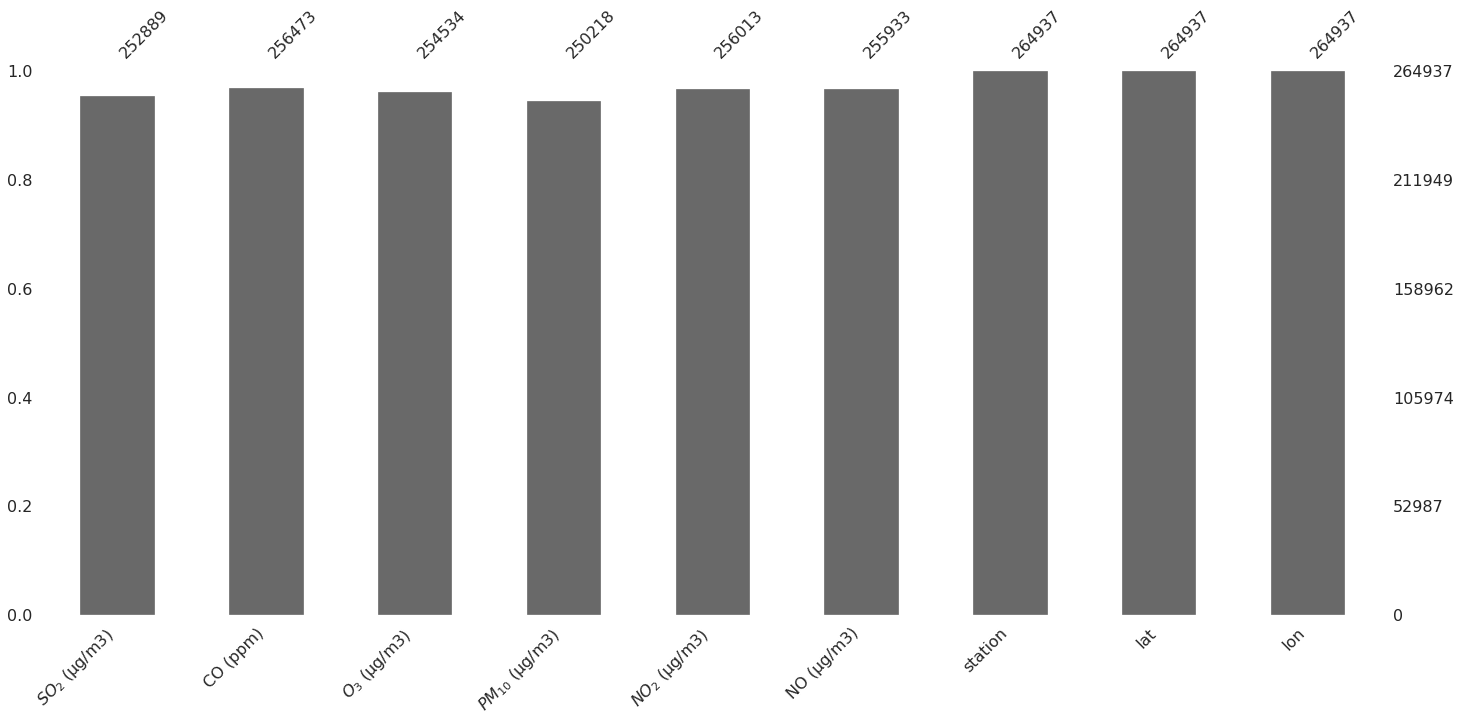

In [139]:
# bar, matrix, heatmap, dendrogram
msno.bar(df_airq)

#### Profiling

Gerando o profiling dos dados de qualidade do ar

In [140]:
show_profiling(
    df_airq,
    title=F_AIRQ.split('/')[-1],
    f_out=f'{os.path.splitext(F_AIRQ)[0]}.html'
)

#### Describe

Descrevendo os dados

In [143]:
show_describe(
    df_airq,
    columns=COLS_AIRQ
)

max  min       mean     median  lower-limit  \
header                                                                  
$SO_2$ (µg/m3)     273.708956  0.0   1.157933   0.522824          0.0   
CO (ppm)             7.660000  0.0   0.379839   0.330000          0.0   
$O_3$ (µg/m3)      151.809363  0.0  14.592121  12.878108          0.0   
$PM_{10}$ (µg/m3)  969.400000  0.0  25.336688  22.200000          0.0   
$NO_2$ (µg/m3)     268.644049  0.0  21.152377  19.413370          0.0   
NO (µg/m3)         684.954409  0.0  37.587178  23.808205          0.0   

                   quartile-1  quartile-3  upper-limit          var  \
header                                                                
$SO_2$ (µg/m3)       0.000000    1.563885     3.909713     5.273061   
CO (ppm)             0.170000    0.530000     1.070000     0.098188   
$O_3$ (µg/m3)        7.307514   19.955118    38.926524    92.933013   
$PM_{10}$ (µg/m3)   14.000000   32.400000    60.000000   320.746257   
$NO_2$ (µg/m3)      12.581869   27.732084    50.457405   146.111324   
NO (µg/m3)           9.339641   47.041653   103.594670  2125.123176   

                         std        mad         amp        rms     kurtosis  \
header                                                                        
$SO_2$ (µg/m3)      2.296315   1.132103  273.708956   2.571740  2950.186933   
CO (ppm)            0.313350   0.224871    7.660000   0.492407    23.109588   
$O_3$ (µg/m3)       9.640177   7.575744  151.809363  17.488929     1.709971   
$PM_{10}$ (µg/m3)  17.909390  12.093993  969.400000  31.027290   126.234637   
$NO_2$ (µg/m3)     12.087652   9.288640  268.644049  24.362549     4.257982   
NO (µg/m3)         46.099058  29.775588  684.954409  59.480340    12.068977   

                        skew   count   nans  
header                                       
$SO_2$ (µg/m3)     34.178821  252889  12048  
CO (ppm)            2.804801  256473   8464  
$O_3$ (µg/m3)       1.058609  254534  10403  
$PM_{10}$ (µg/m3)   5.306224  250218  14719  
$NO_2$ (µg/m3)      1.234784  256013   8924  
NO (µg/m3)          2.967954  255933   9004

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 264937 entries, 2013-09-01 04:00:00 to 2015-12-31 00:00:00
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   $SO_2$ (µg/m3)     252889 non-null  float64
 1   CO (ppm)           256473 non-null  float64
 2   $O_3$ (µg/m3)      254534 non-null  float64
 3   $PM_{10}$ (µg/m3)  250218 non-null  float64
 4   $NO_2$ (µg/m3)     256013 non-null  float64
 5   NO (µg/m3)         255933 non-null  float64
 6   station            264937 non-null  object 
 7   lat                264937 non-null  float64
 8   lon                264937 non-null  float64
dtypes: float64(8), object(1)
memory usage: 20.2+ MB


None

#### Analysis

Distplot com média diária

'AV ACM - DETRAN'

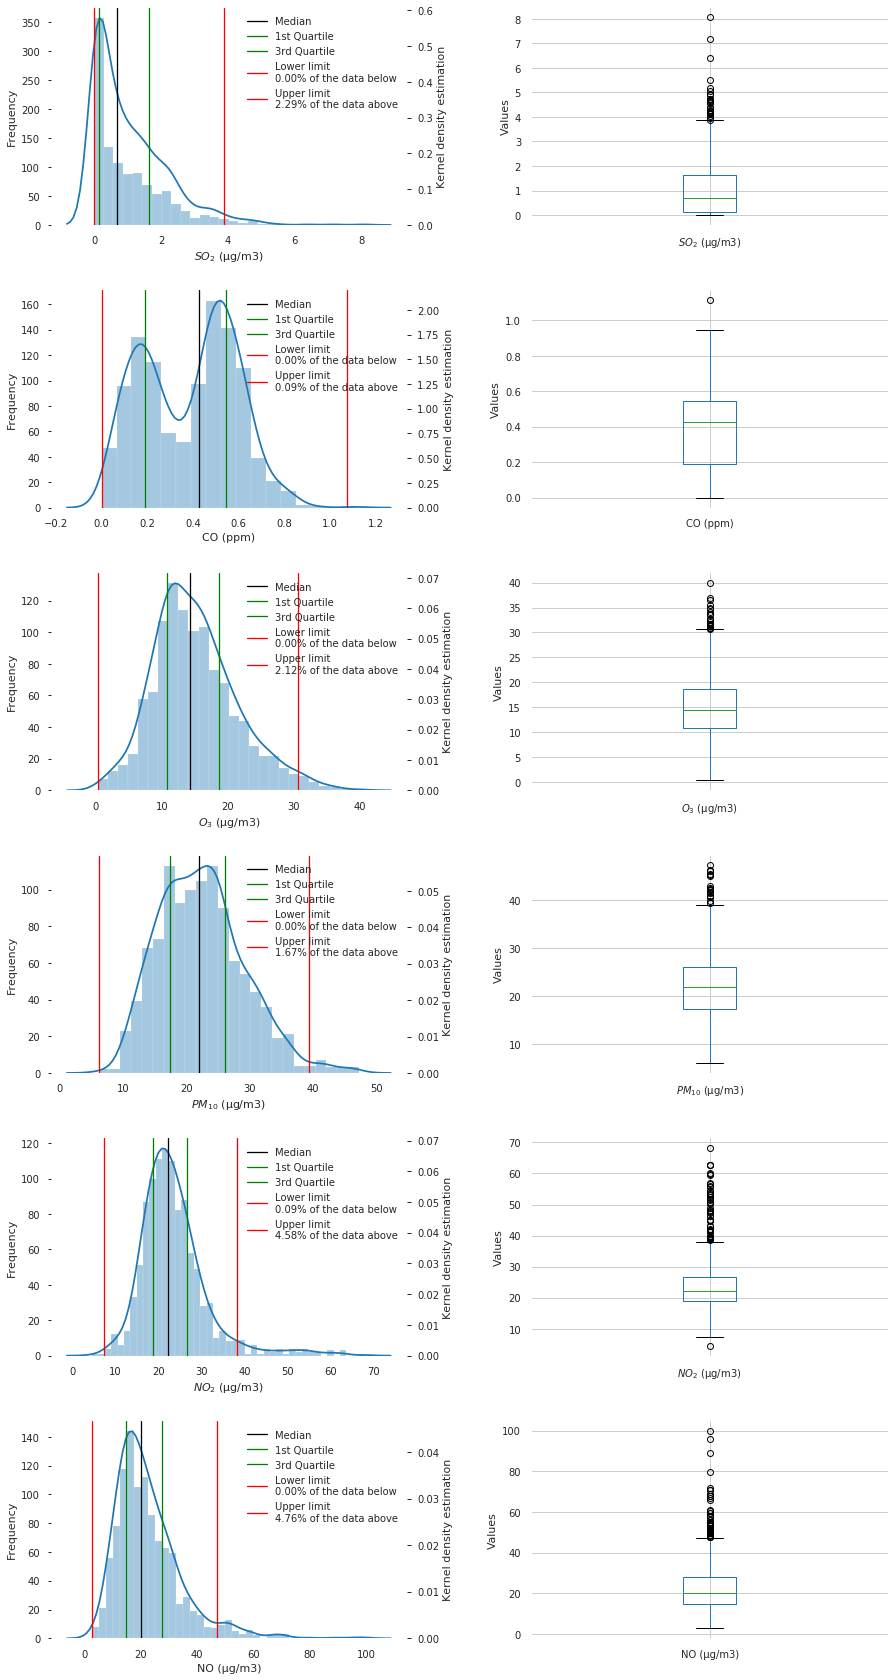

'AV BARROS REIS'

<Figure size 432x288 with 0 Axes>

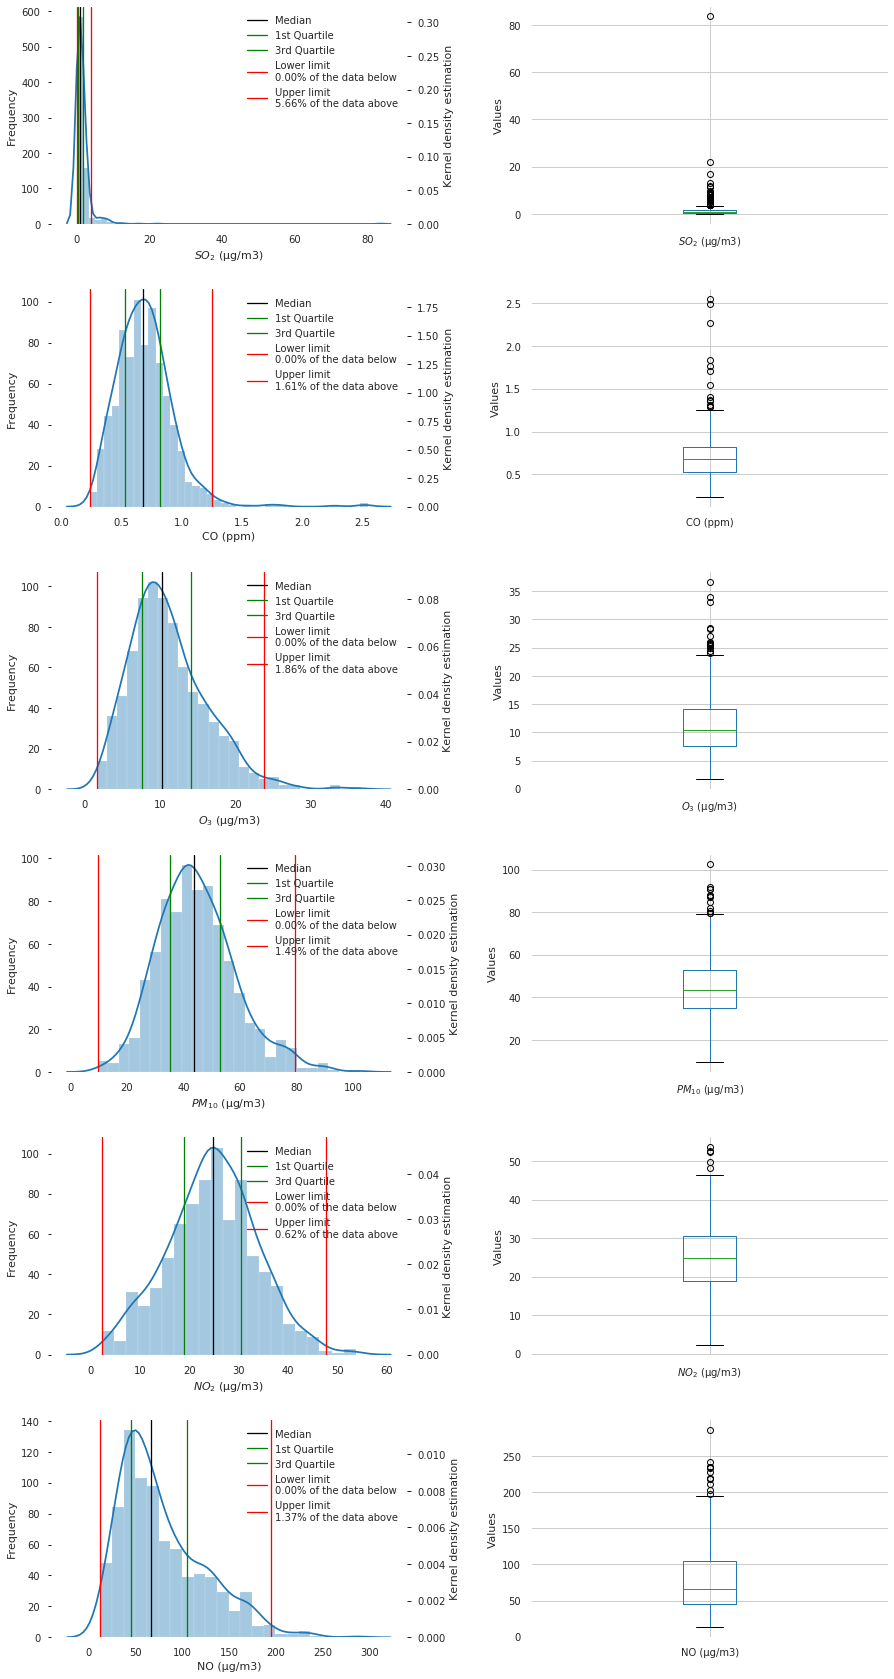

'CAMPO GRANDE'

<Figure size 432x288 with 0 Axes>

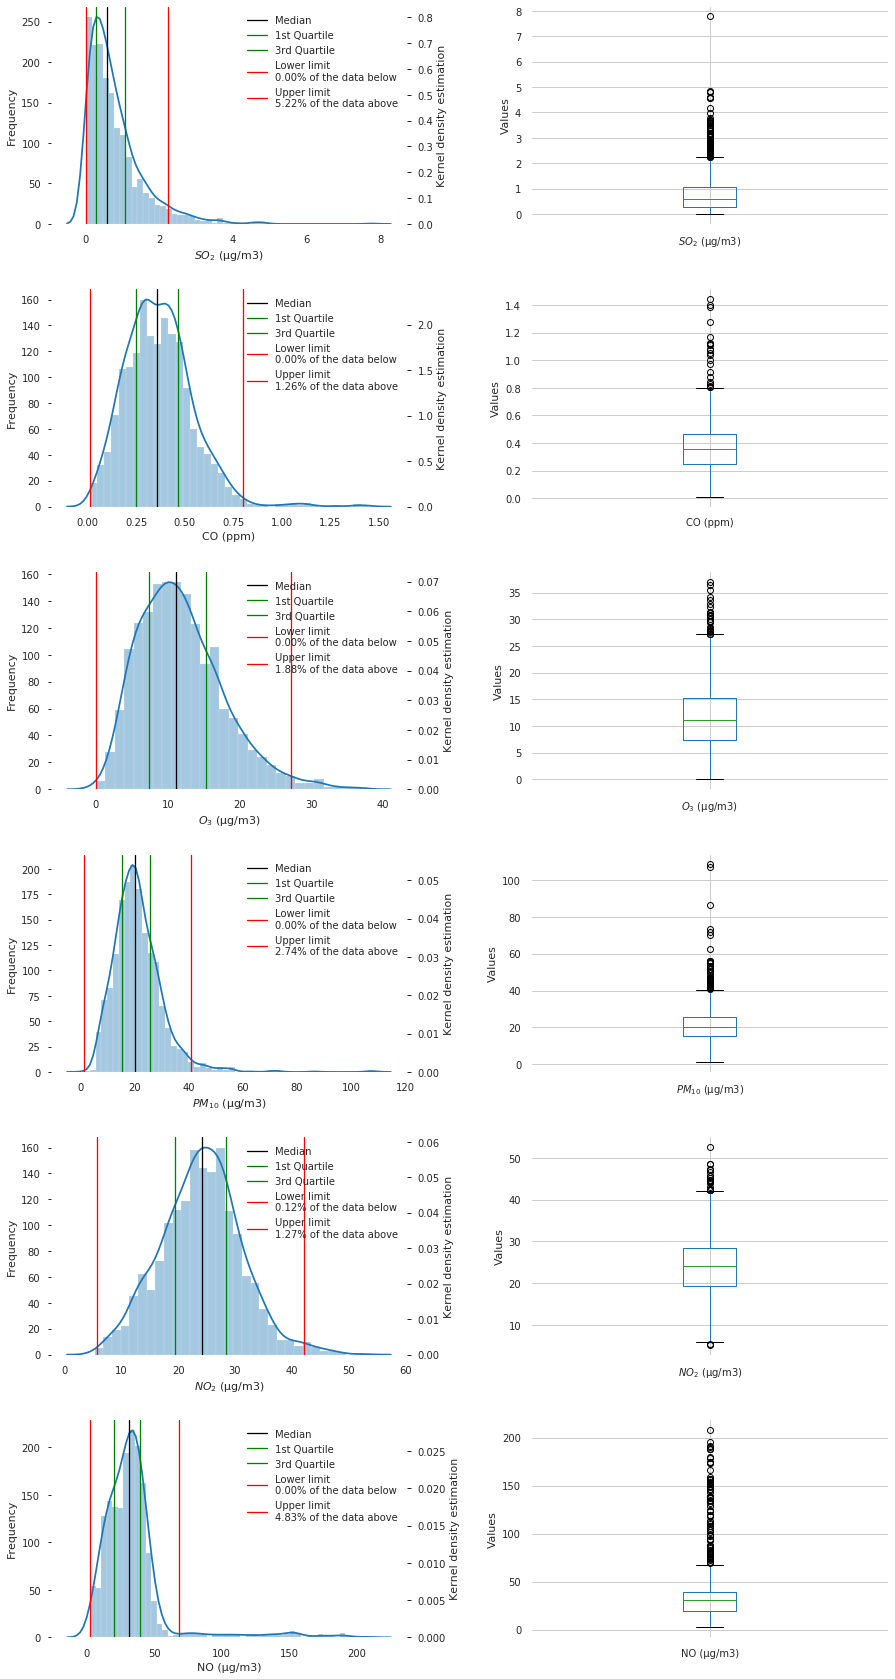

'DIQUE DO TORORÓ'

<Figure size 432x288 with 0 Axes>

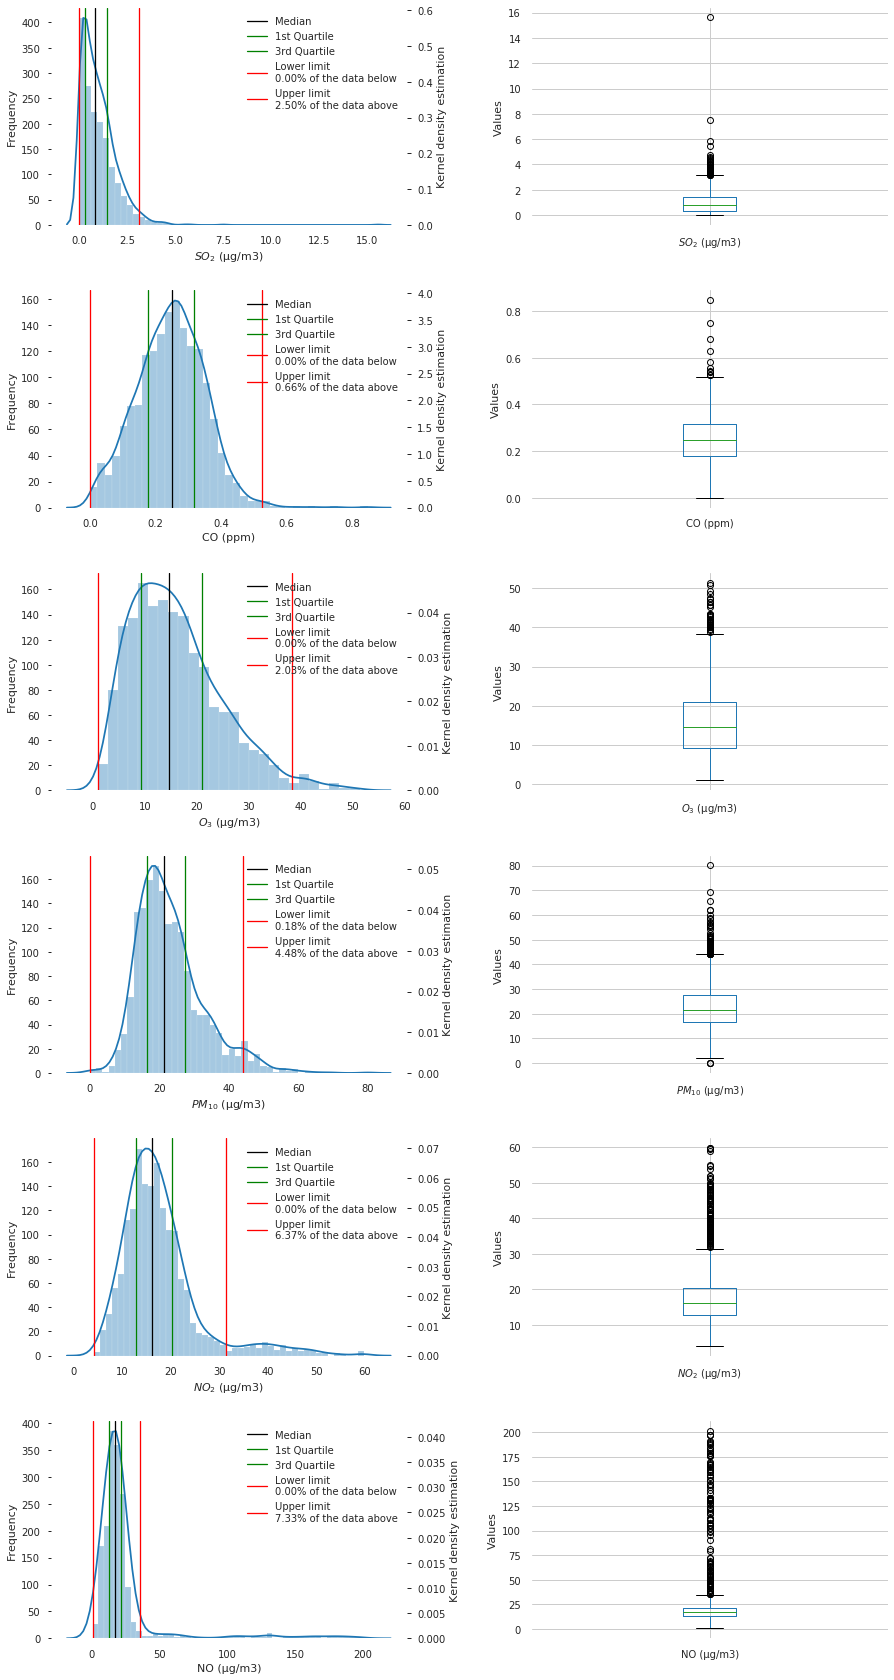

'ITAIGARA'

<Figure size 432x288 with 0 Axes>

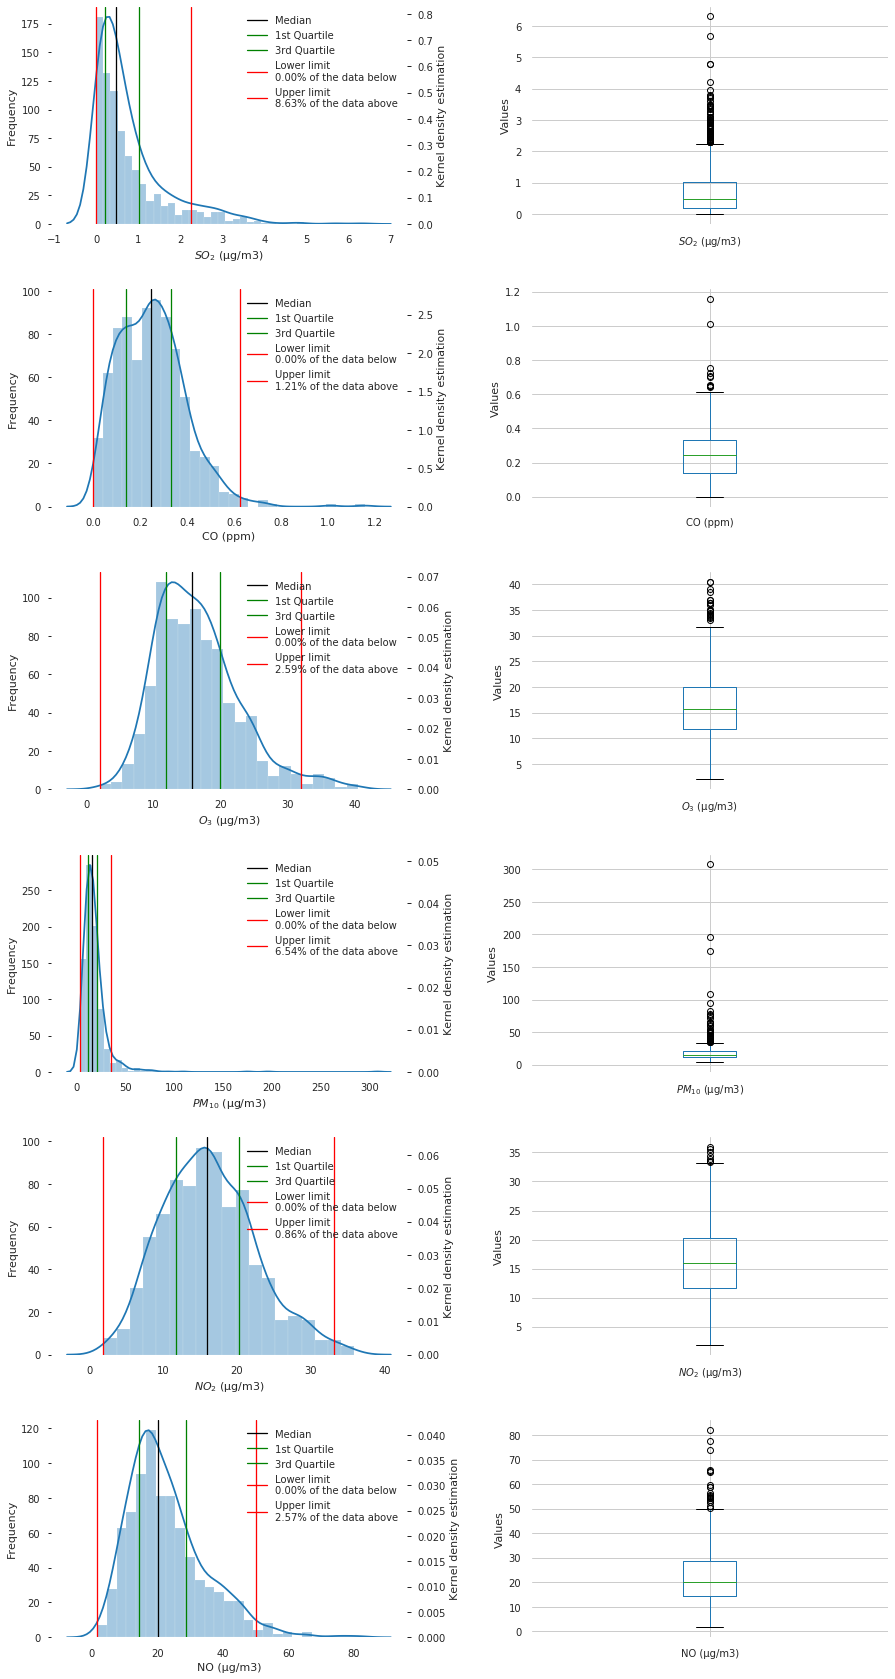

'PARALELA-CAB'

<Figure size 432x288 with 0 Axes>

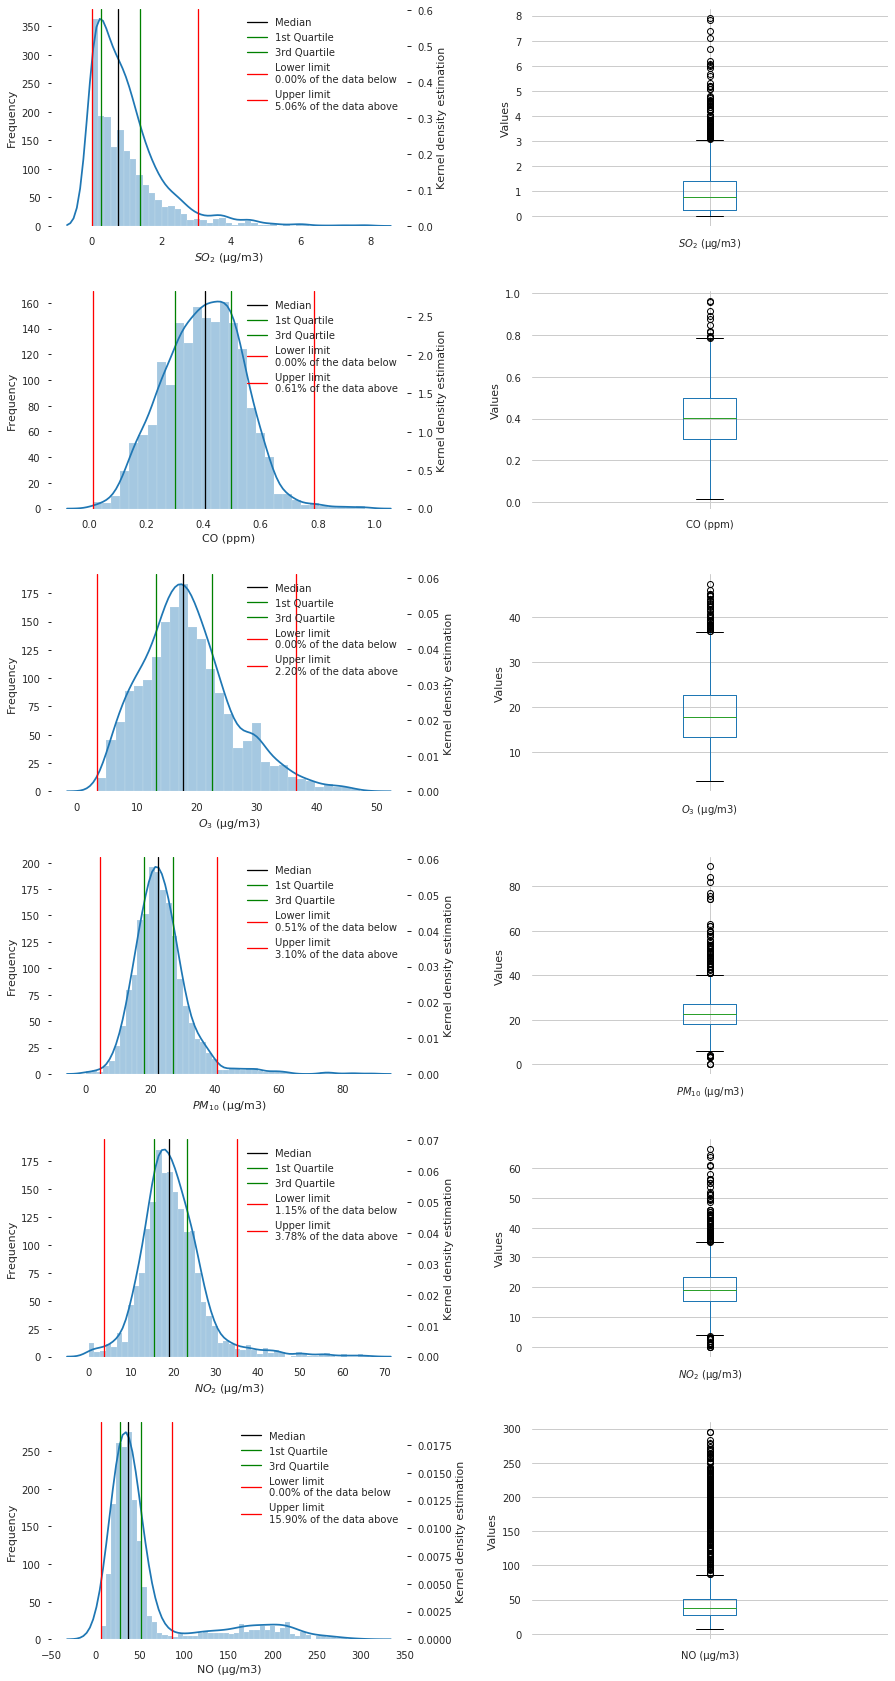

'PIRAJÁ'

<Figure size 432x288 with 0 Axes>

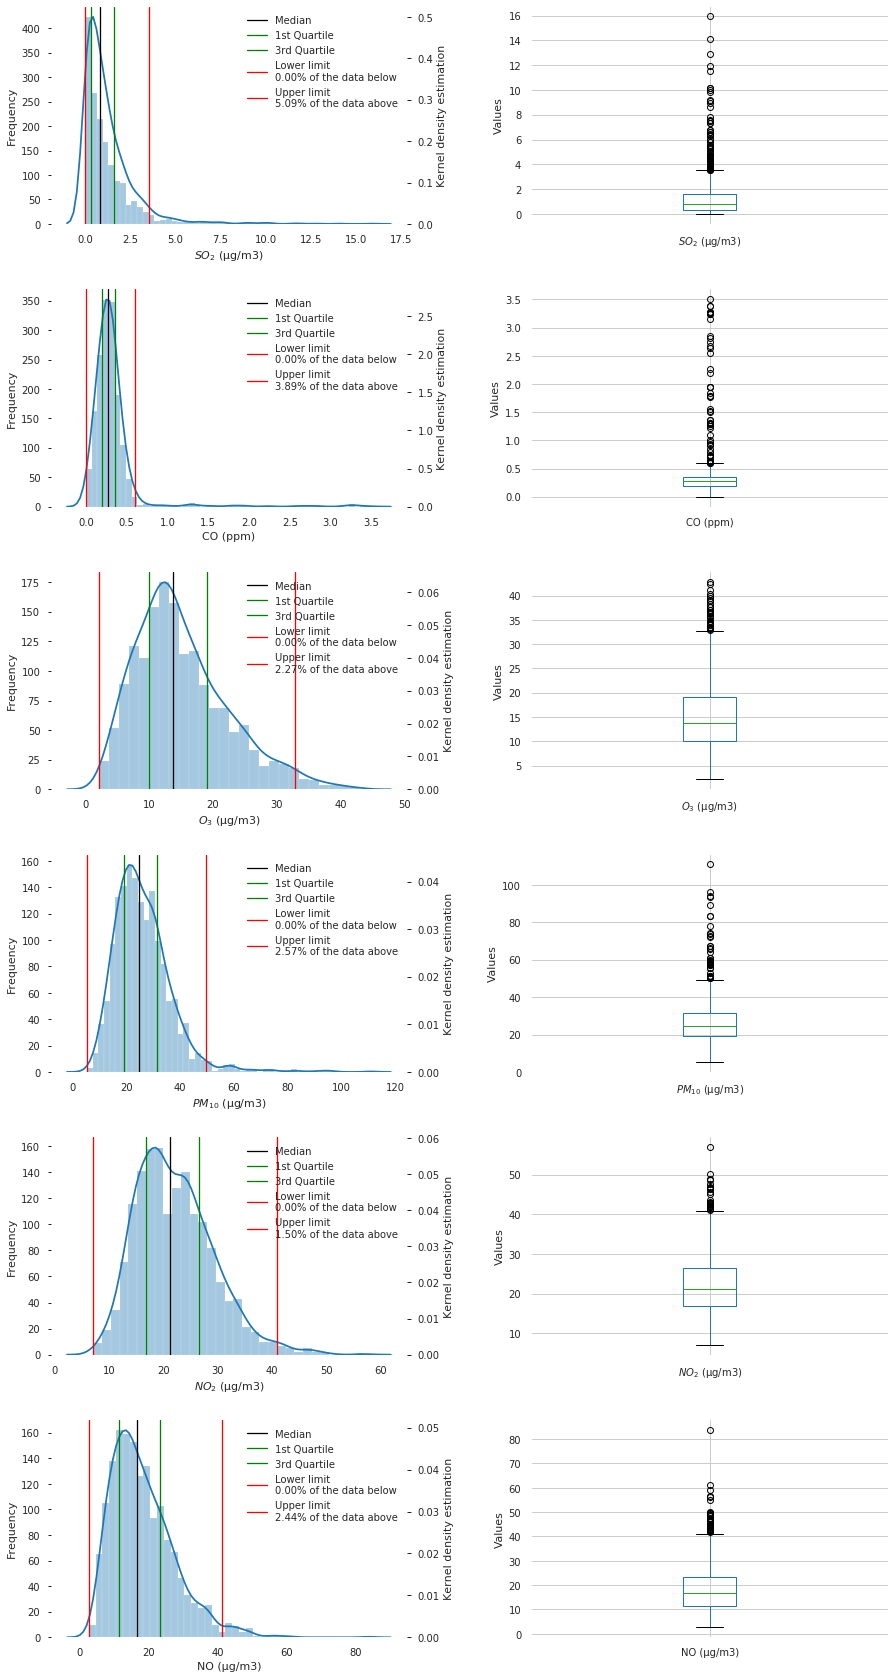

'RIO VERMELHO'

<Figure size 432x288 with 0 Axes>

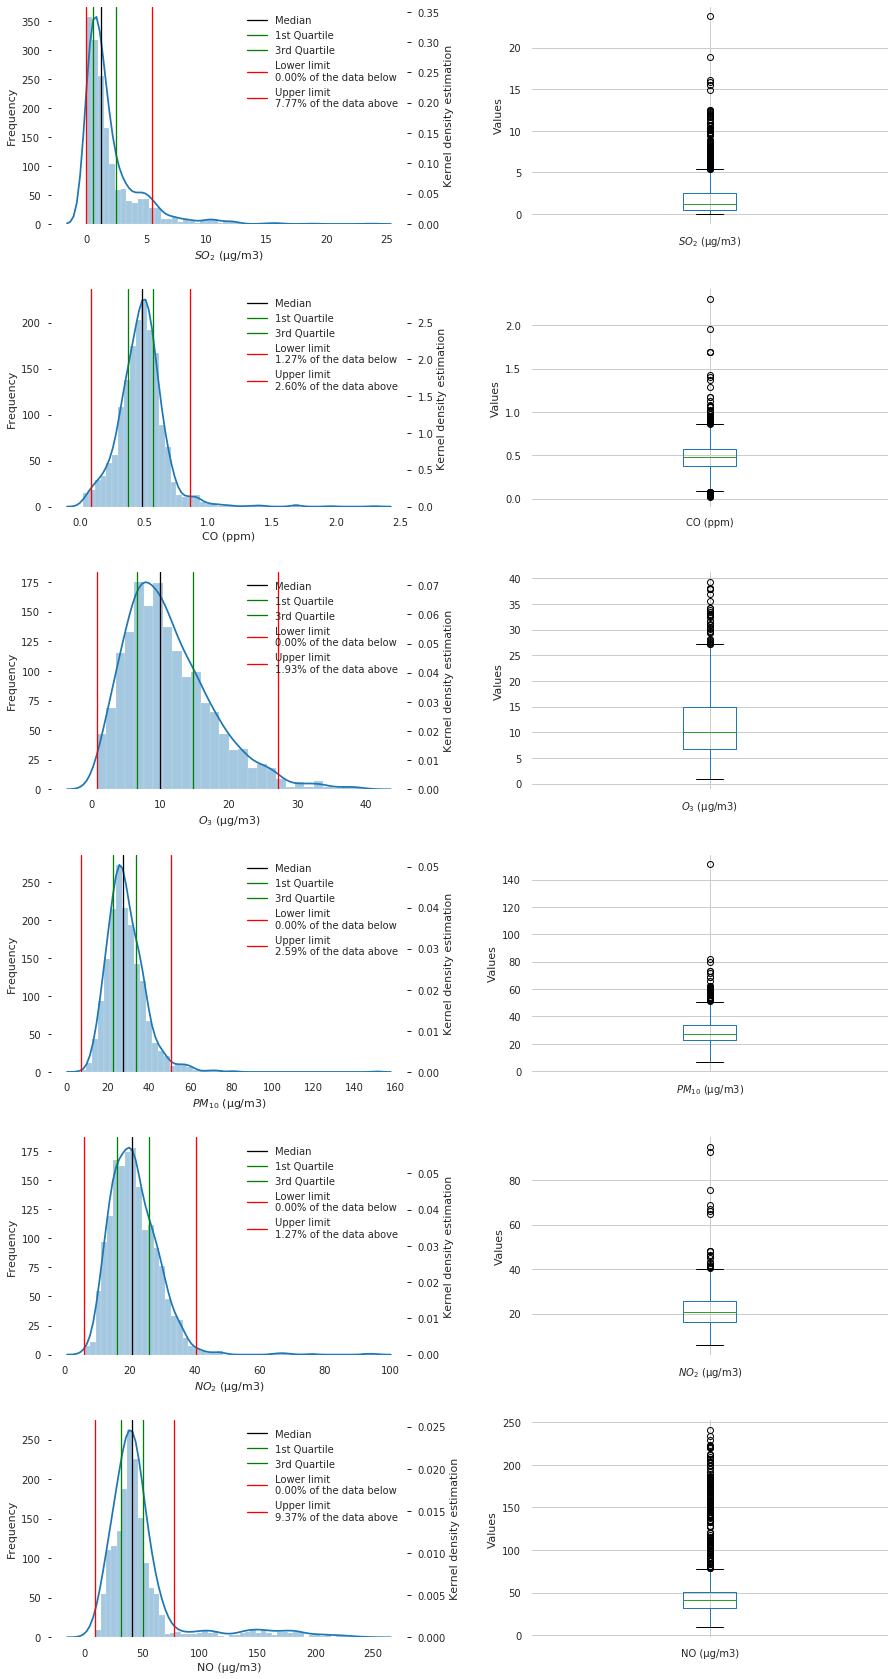

<Figure size 432x288 with 0 Axes>

In [151]:
stations = np.unique(df_airq['station'])

if not os.path.exists(f'{path_results}/charts'):
    os.mkdir(f'{path_results}/charts')
if not os.path.exists(f'{path_results}/charts/distplot'):
    os.mkdir(f'{path_results}/charts/distplot')

for st in stations:
    aux = df_airq.loc[df_airq['station'] == st]
    aux = aux[COLS_AIRQ]
    aux = aux.groupby(pd.Grouper(freq='D')).mean()
    aux.fillna(limit=2, method='ffill', inplace=True)
    
    out = f'{PATH_RESULTS}/charts/distplot/{st}-distplot-daily_average.png'
    display(st)
    plot_distributions(aux, out)

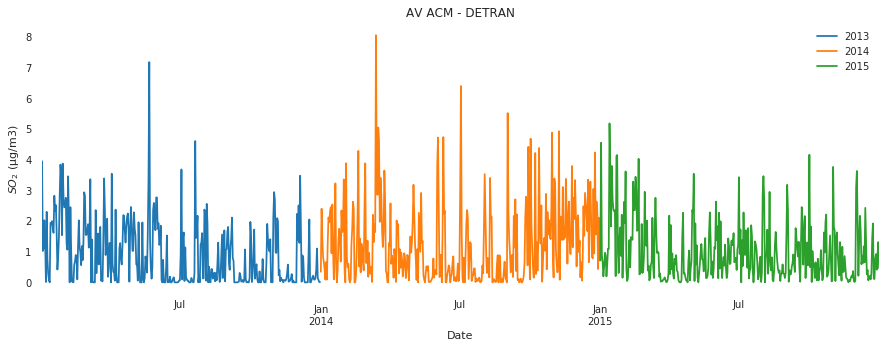

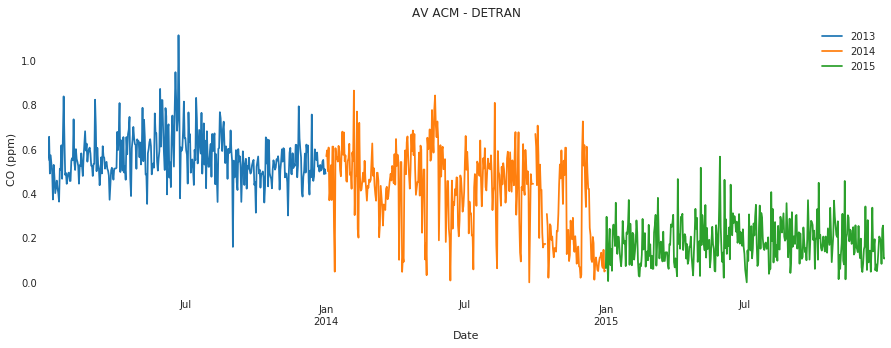

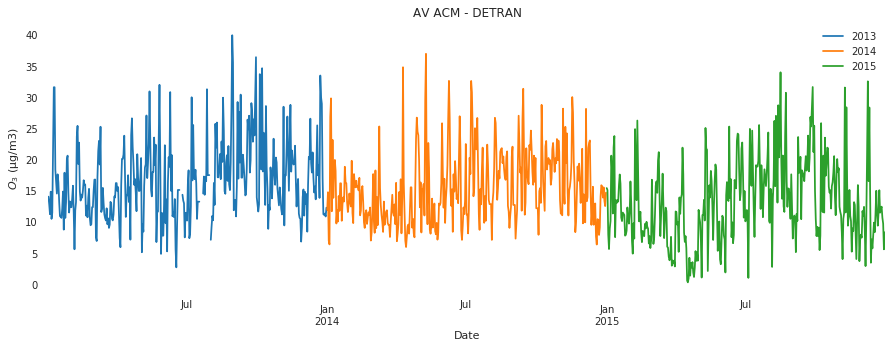

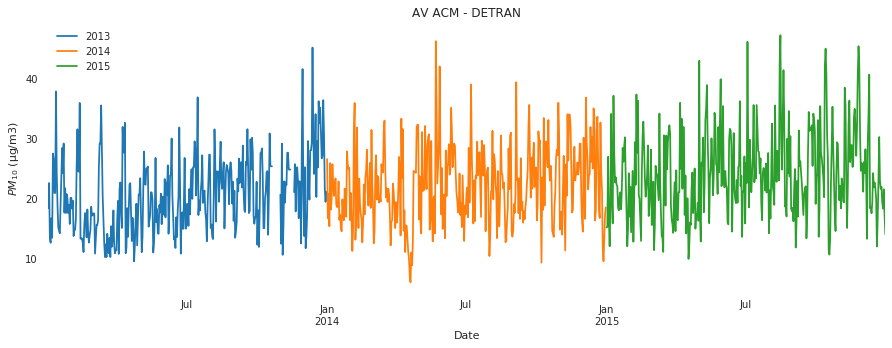

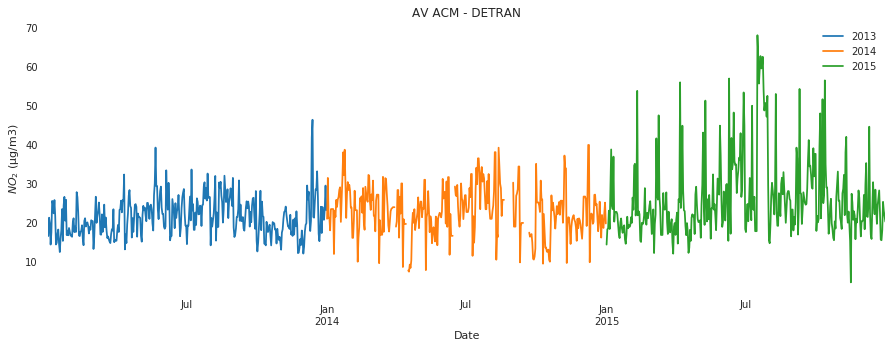

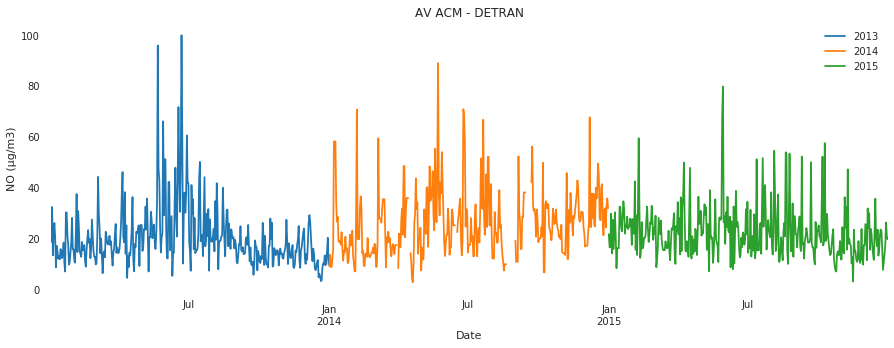

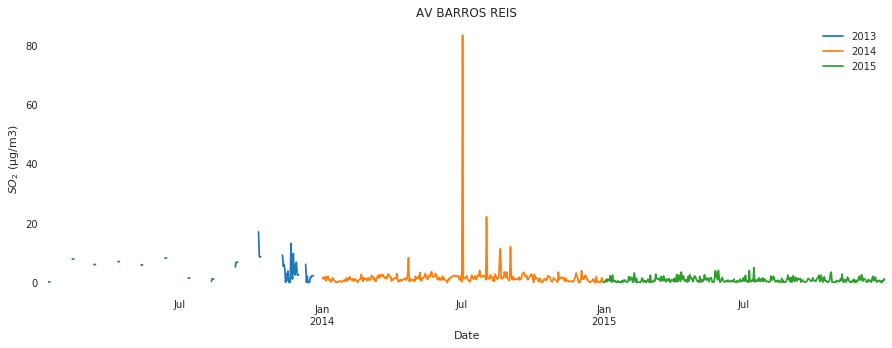

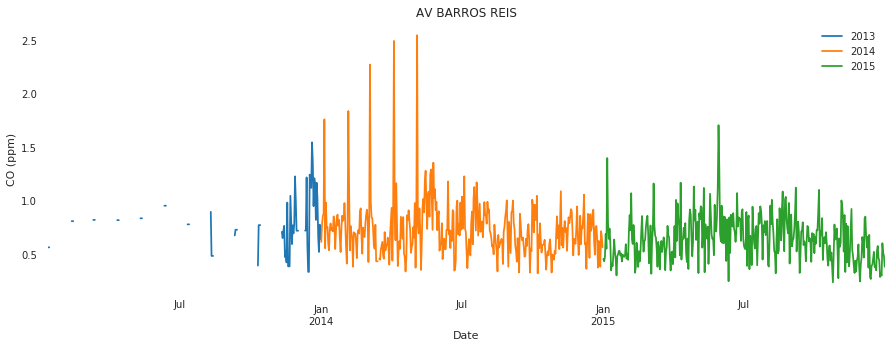

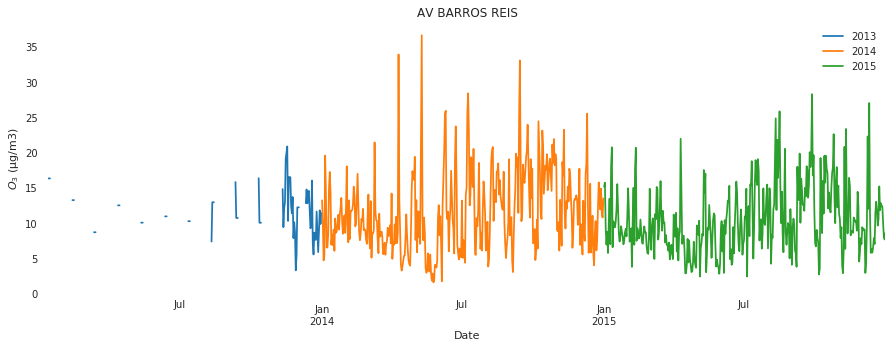

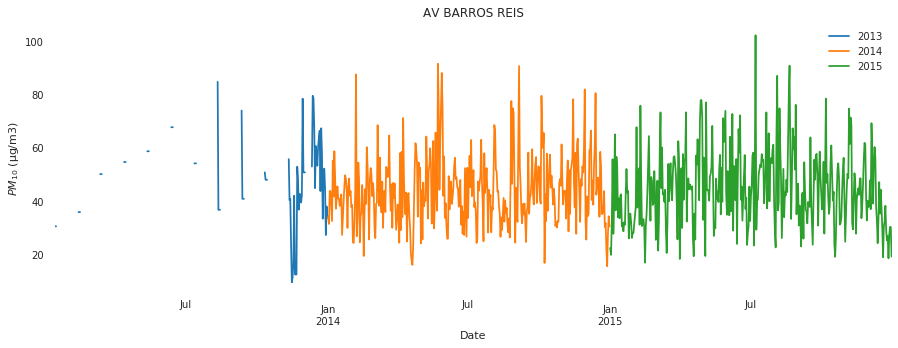

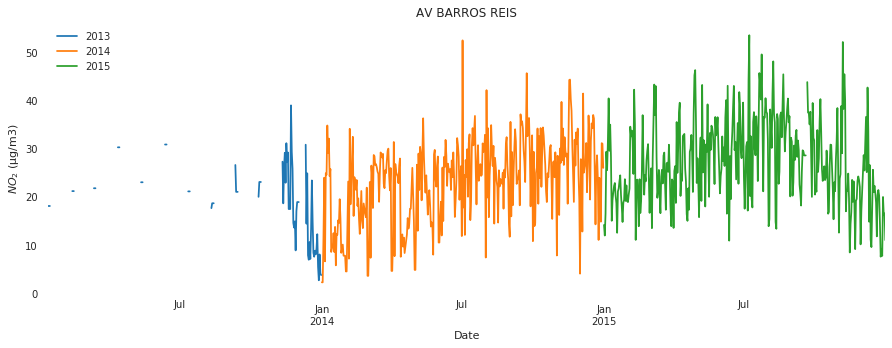

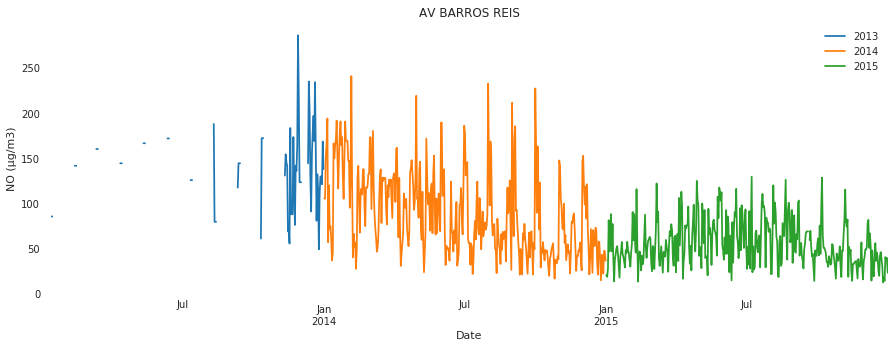

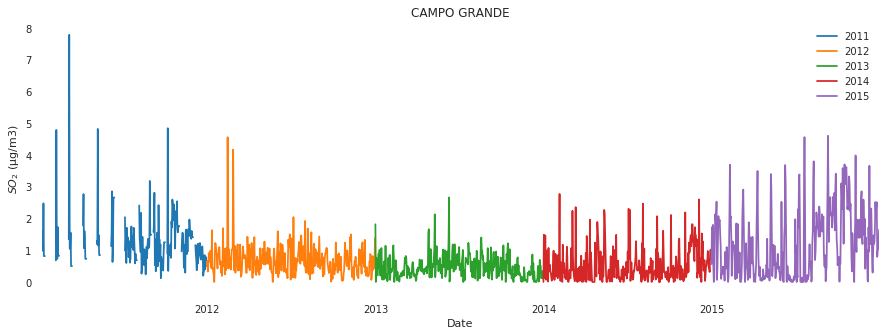

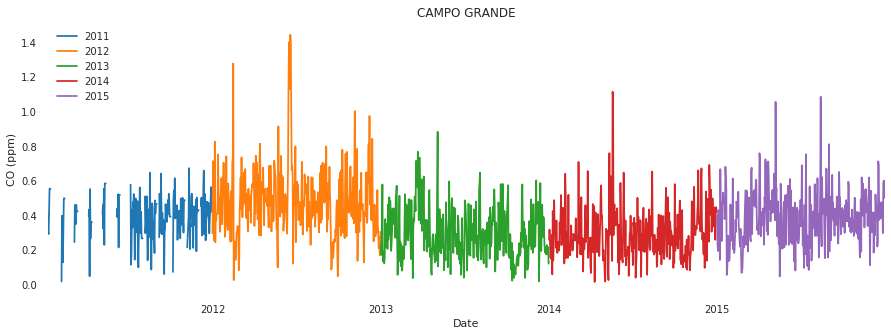

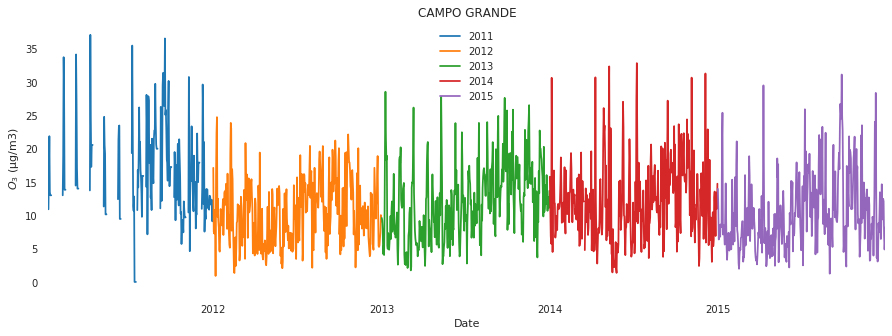

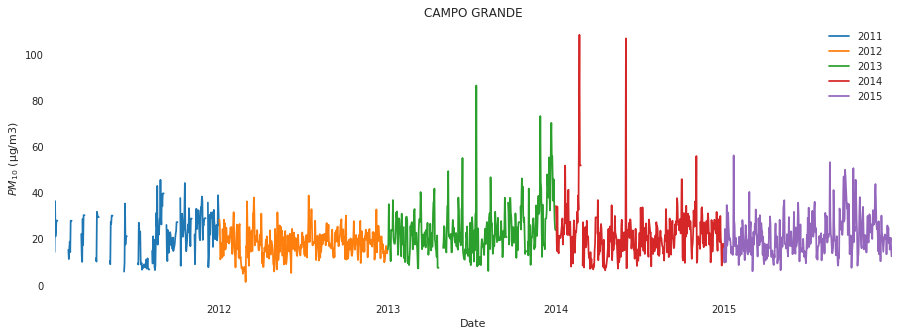

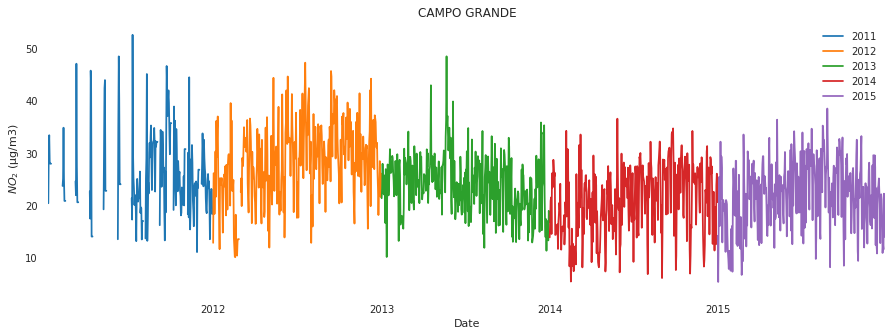

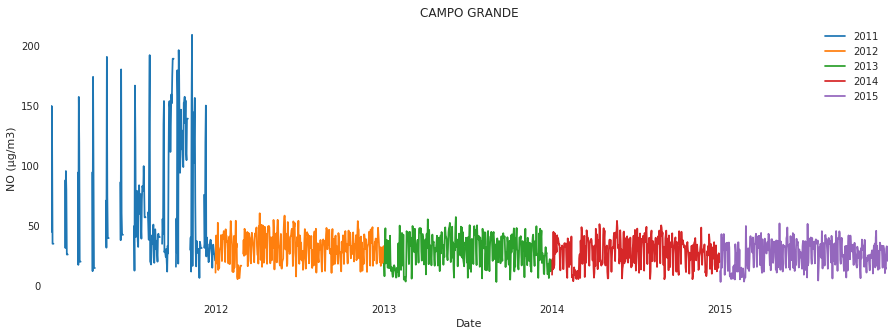

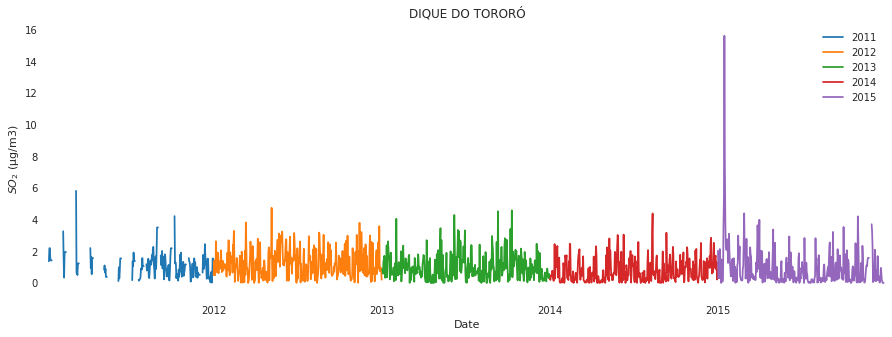

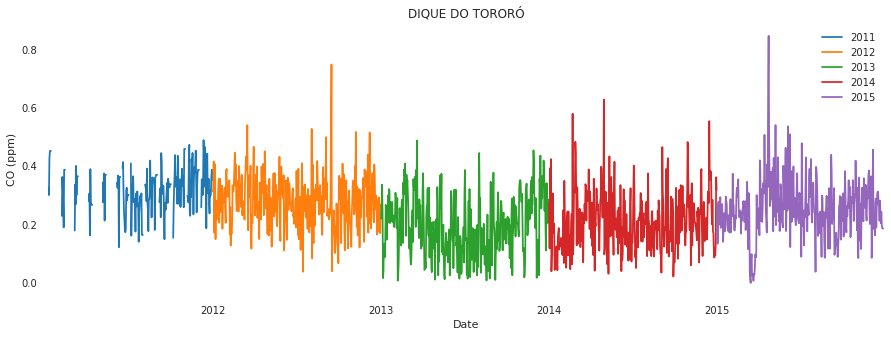

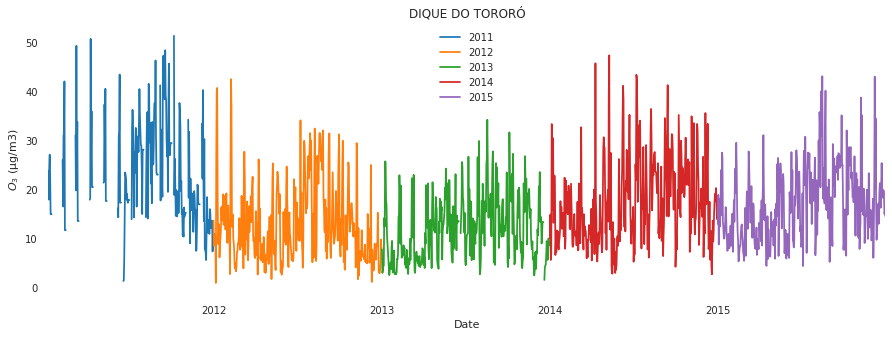

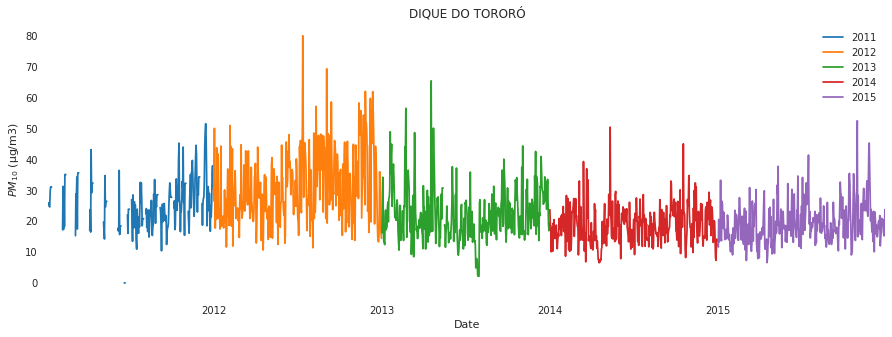

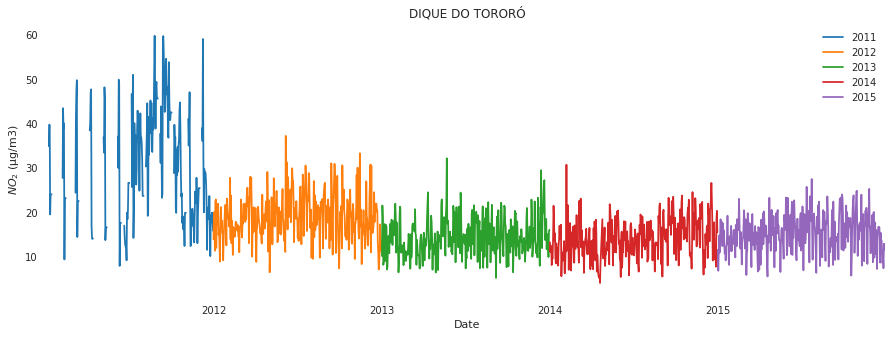

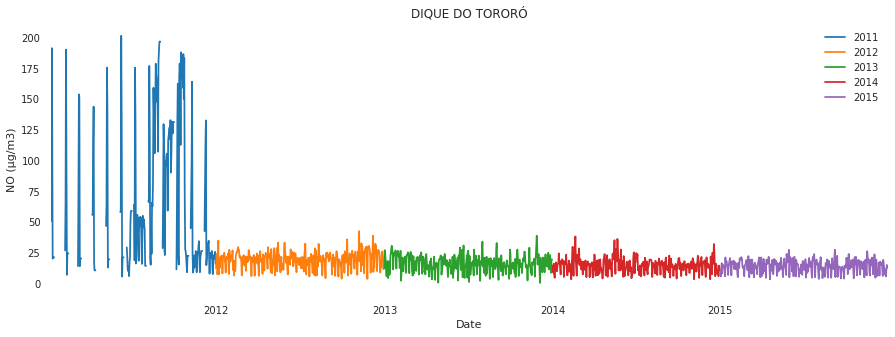

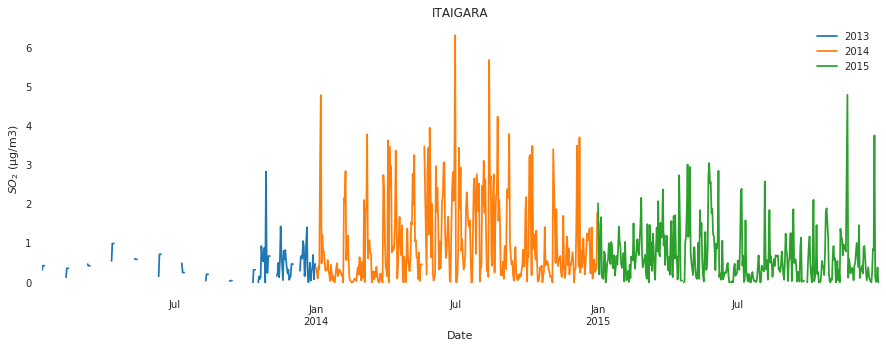

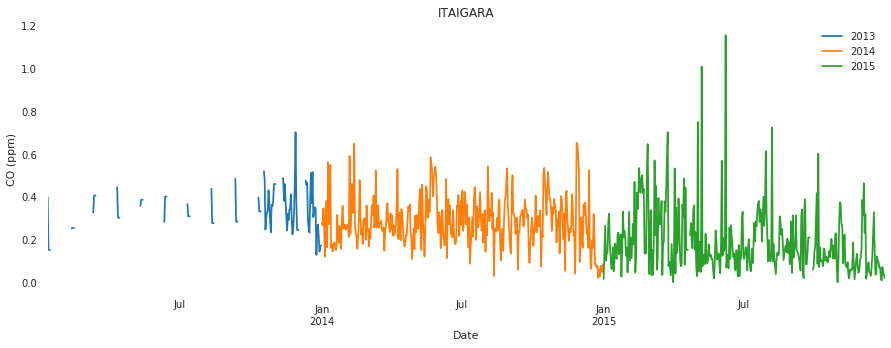

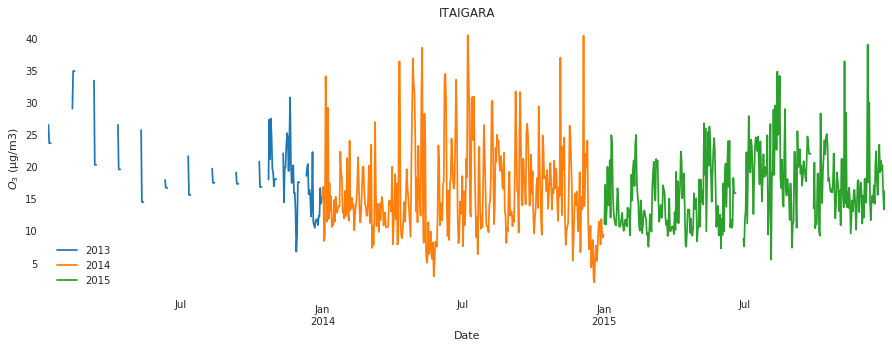

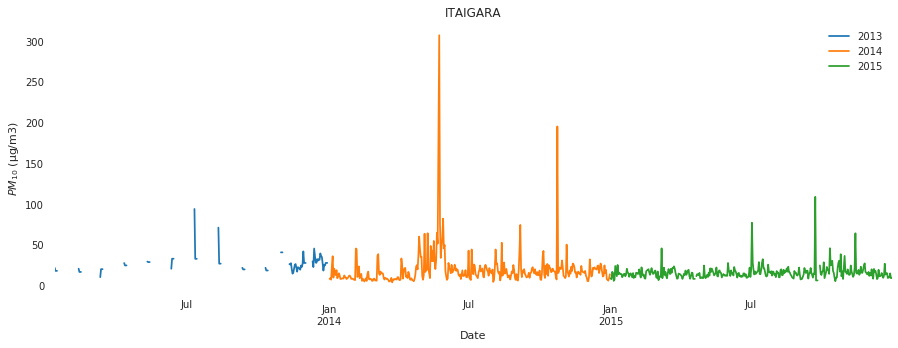

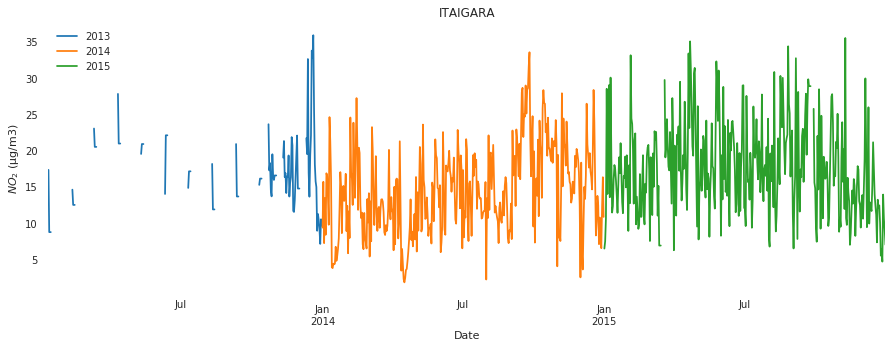

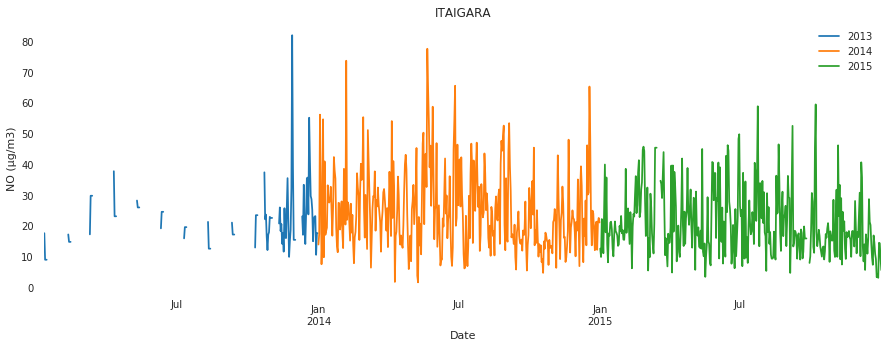

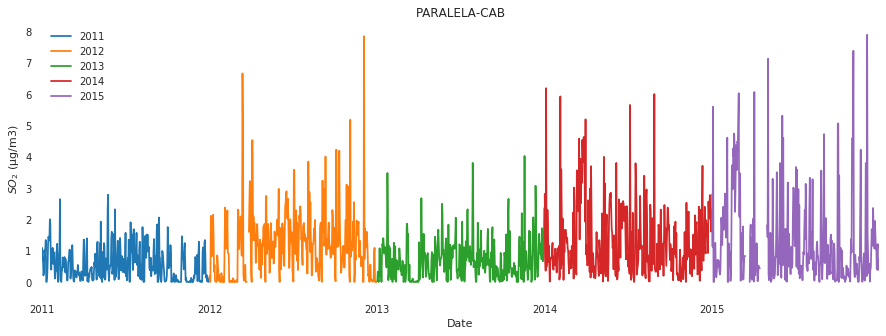

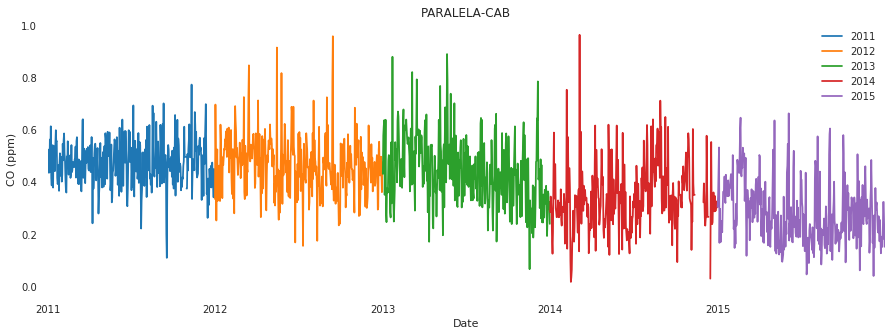

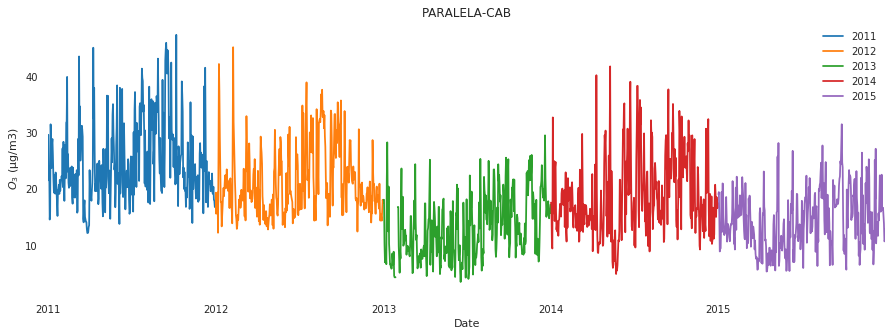

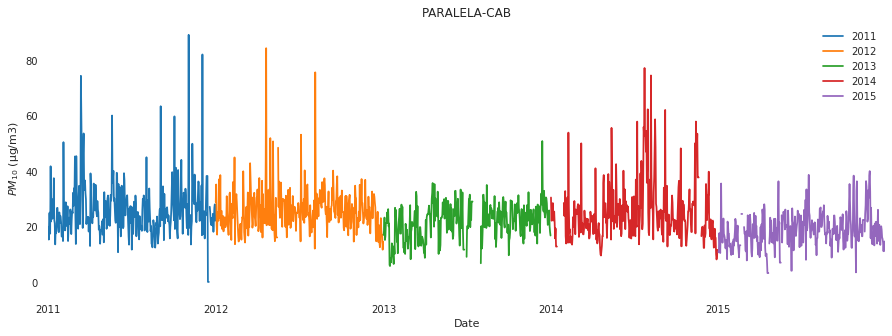

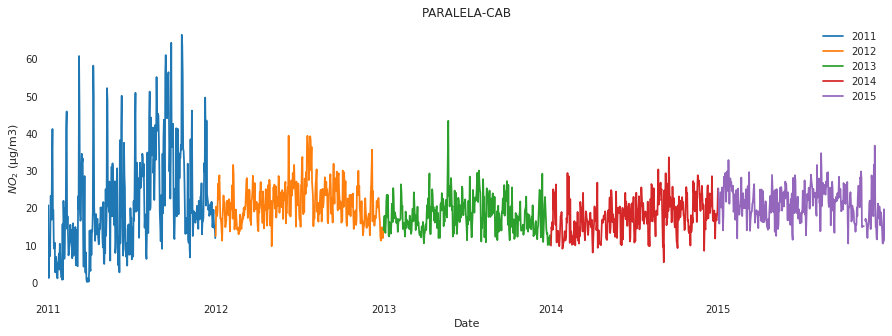

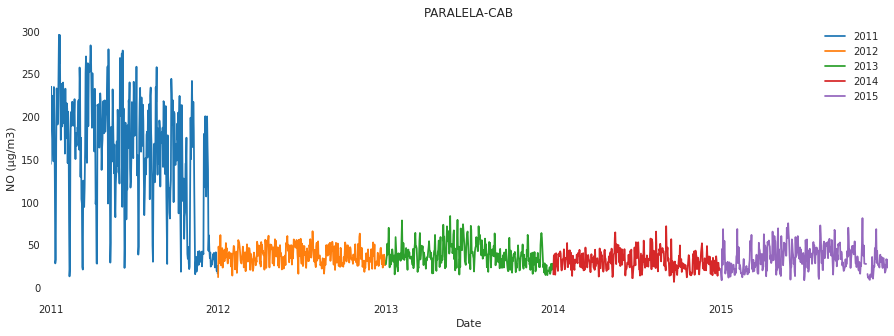

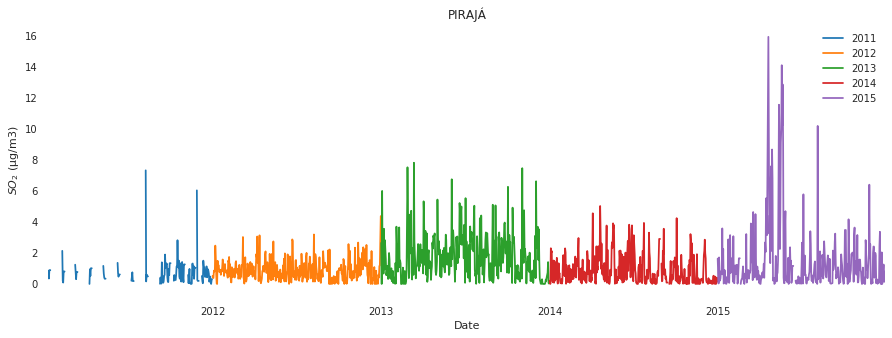

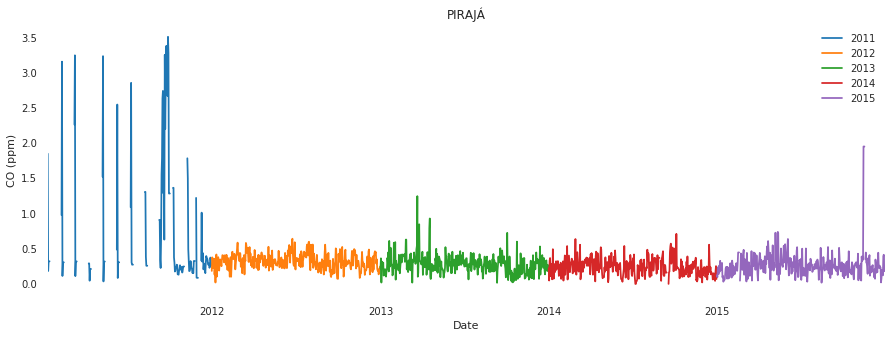

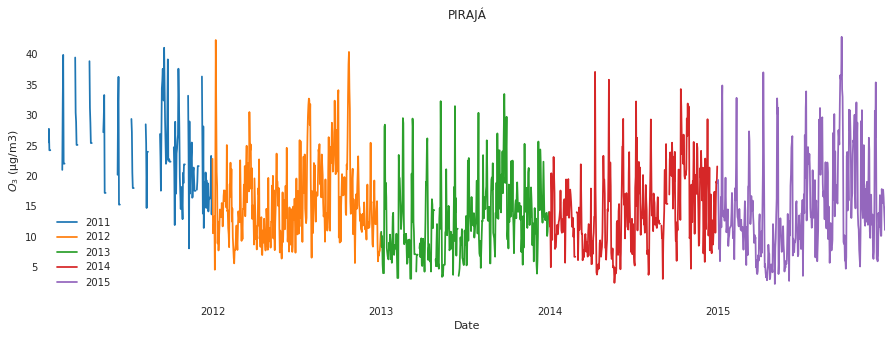

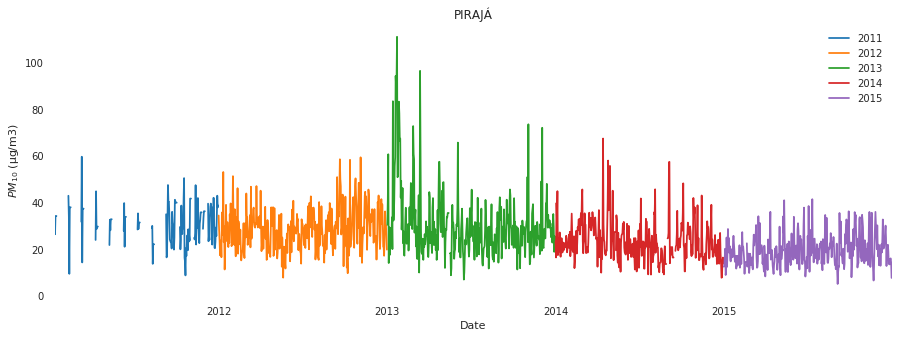

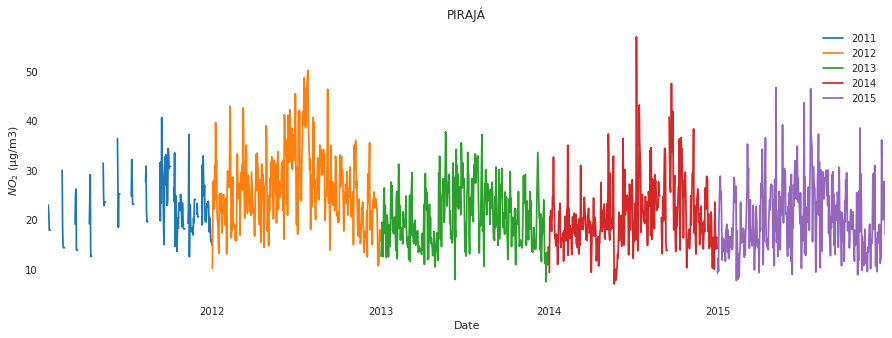

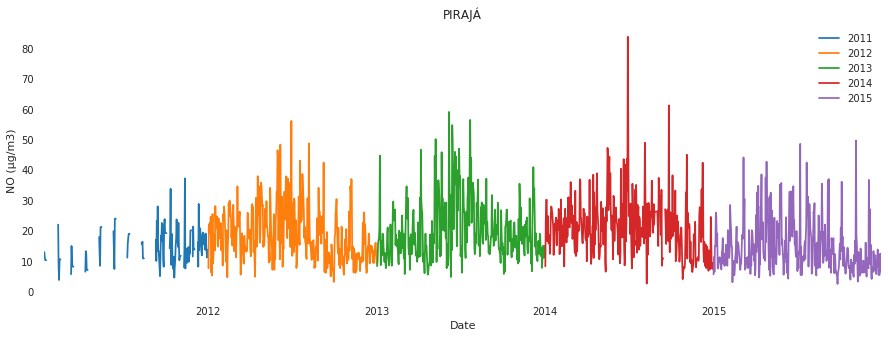

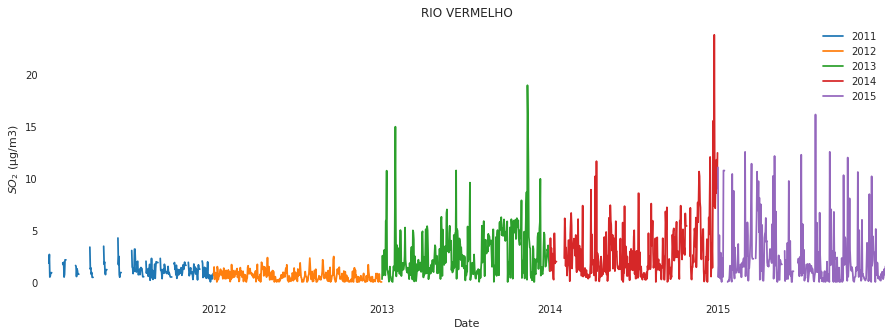

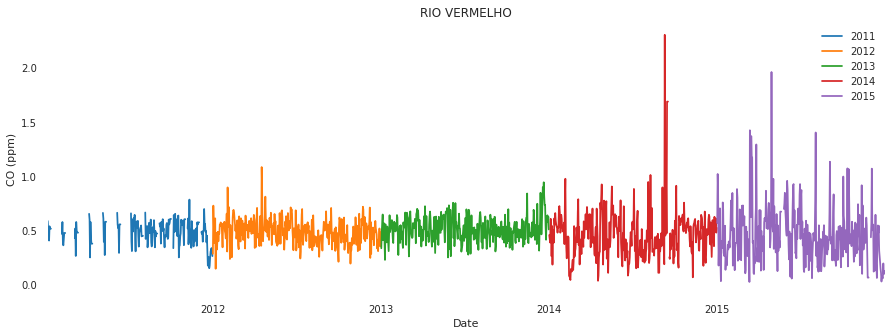

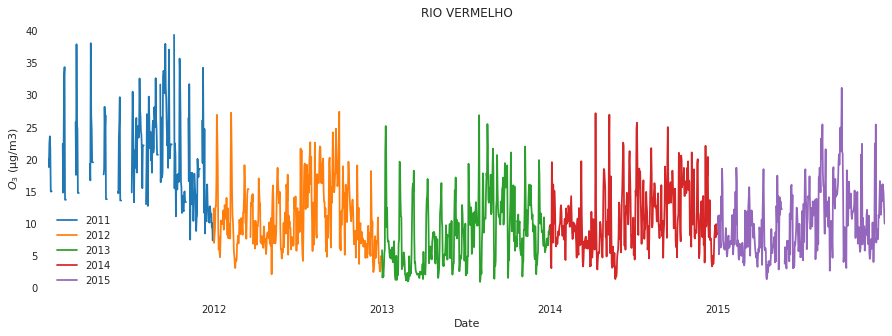

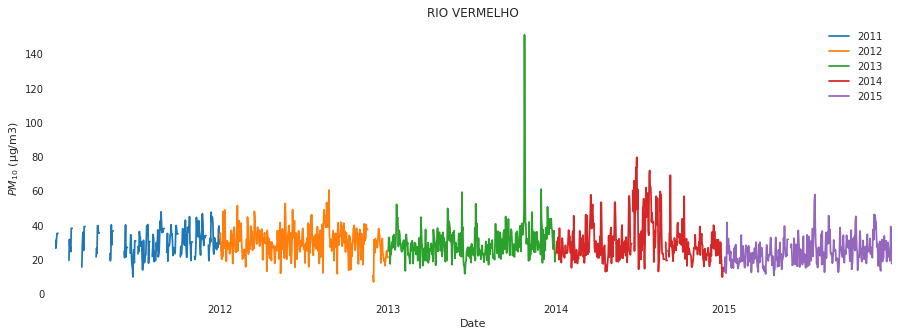

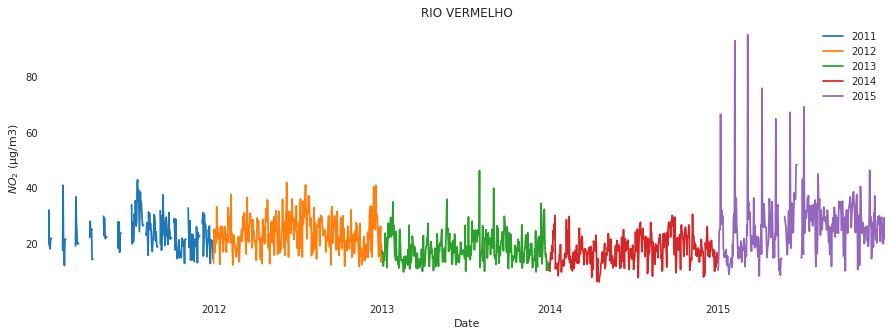

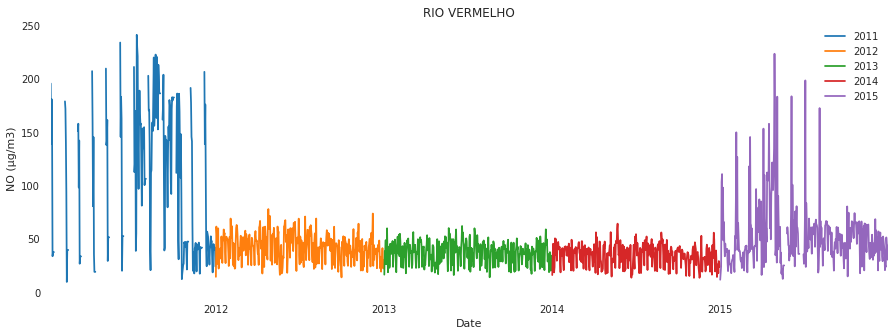

In [154]:
stations = np.unique(df_airq['station'])
for st in stations:
    aux = df_airq.loc[df_airq['station'] == st]
    aux = aux[COLS_AIRQ]

    for col in aux:
#         aux[col] = pd.Series(aux[col]).fillna(limit=2, method='ffill')
        group = aux[col].groupby(pd.Grouper(freq='D')).mean()
        group.fillna(limit=2, method='ffill', inplace=True)
        
        fig, ax = plt.subplots()
        years = np.unique(group.index.year)
        for year in years:
            group.loc[group.index.year == year].plot(
                figsize=(15,5), label=year, title=st, ax=ax
            )

        ax.set_ylabel(col)
        ax.set_xlabel('Date')
        ax.legend()
#         plt.axhline(y=2, linestyle='-', linewidth=1.3, color='black', label='Mediana')
#         plt.legend(loc='best', bbox_to_anchor=(0.5, 0., 0.5, 0.5))
        plt.show()

---

### Weather

#### Dataframe

In [ ]:
df_wthr = pd.read_csv(F_WTHR, low_memory=False, compression='gzip')
df_wthr

#### Missingno

In [ ]:
msno.bar(df_wthr)

#### Profiling

In [ ]:
show_profiling(
    df_wthr,
    title=F_WTHR.split('/')[-1],
    f_out=f'{os.path.splitext(F_WTHR)[0]}.html'
)

#### Describe

In [ ]:
show_describe(df_wthr, columns=COLS_WTHR)

#### Plot

---

### Datasus

#### Dataframe

In [ ]:
df_dsus = pd.read_csv(F_DSUS, low_memory=False, compression='gzip')
df_dsus

#### Missingno

In [ ]:
msno.bar(df_dsus)

#### Profiling

In [ ]:
show_profiling(
    df_dsus,
    title=f_dsus.split('/')[-1],
    f_out=f'{os.path.splitext(f_dsus)[0]}.html'
)

#### Describe

In [ ]:
show_describe(
    df_dsus,
    columns=[
        'UTI_MES_TO',
        'UTI_INT_TO',
        'VAL_SH',
        'VAL_SP',
        'DIAS_PERM',
    ]
)

#### Plot